# Week 3 - Classification 分類

This week, we shift from gathering human textual classifications through crowdsourcing, to using machine learning models and algorithms that train on those human classifications and extend them to documents far too numerous to read. If you recall, *clustering* allows us to stably partition text data (e.g., documents, turns of conversation) according to all patterns of covariation among available text features. *Classification*, by contrast, partitions text data according to only those features and their variation that enable us to mimic and extrapolate human annotations.

In this notebook, we will show how to use a variety of classification methods, including Naïve Bayes, Logistic regression, K-nearest neighbor, decision trees and random forests, support vector machines and even a simple neural network, the perceptron. We will also demonstrate ensemble techniques that can link several such methods into a single, more accurate, classification pipeline. We will finally learn to use conventions and metrics to evaluate classifier performance on out-of-sample data. 

For this notebook we will be using the following packages.

本週，我們從通過眾包收集人類文本分類轉向使用機器學習模型和算法，這些模型和算法對這些人類分類進行訓練，並將其擴展到數量太多而無法閱讀的文檔。如果您還記得，聚類允許我們根據可用文本特徵之間的所有協變模式穩定地劃分文本數據（例如，文檔、對話輪次）。相比之下，分類僅根據那些使我們能夠模仿和推斷人類註釋的特徵及其變化來劃分文本數據。

在本筆記本中，我們將展示如何使用各種分類方法，包括樸素貝葉斯、邏輯回歸、K-最近鄰、決策樹和隨機森林、支持向量機，甚至是一個簡單的神經網絡感知器。我們還將演示集成技術，該技術可以將多個此類方法鏈接到一個更準確的分類管道中。我們最終將學習使用約定和度量來評估分類器對樣本外數據的性能。

對於此筆記本，我們將使用以下軟件包。

[機器學習常用的分類器比較](https://codertw.com/%E7%A8%8B%E5%BC%8F%E8%AA%9E%E8%A8%80/45494/)
[【機器學習懶人包】從數據分析到模型整合，各種好用的演算法全都整理給你啦！](https://buzzorange.com/techorange/2019/08/13/machine-learning-algorithm-collection/)

In [1]:
#Special module written for this class
#This provides access to data and to helper functions from previous weeks
#Make sure you update it before starting this notebook
import lucem_illud_2020 #pip install -U git+git://github.com/Computational-Content-Analysis-2020/lucem_illud_2020.git

#All these packages need to be installed from pip
#For ML
import sklearn
import sklearn.naive_bayes
import sklearn.tree
import sklearn.ensemble
import sklearn.neural_network
import sklearn.decomposition

import numpy as np #arrays
import matplotlib.pyplot as plt #Plots
import matplotlib.colors # For nice colours
import seaborn #Makes plots look nice, also heatmaps
import scipy as sp #for interp

#These are from the standard library
import collections
import os
import os.path
import random
import re
import glob
import pandas
import requests
import json
import math

#This 'magic' command makes the plots work better
#in the notebook, don't use it outside of a notebook.
#Also you can ignore the warning
%matplotlib inline

# Simple Simulated Examples 簡單的模擬示例

Here we create a sandbox for you to explore different types of classified data and how different statistical classifiers perform on each type.

在這裡，我們為您創建了一個沙箱，以探索不同類型的分類數據以及不同統計分類器對每種類型的執行情況。

## Generating example data 生成示例數據

We start by loading one of the "cartoon" or simplified data sets and then dividing it into training and testing sets. To maximize our ability to visualize, each dataset involves two classes, colored yellow and blue, arrayed along two dimensions (`x` and `y`). 

The four data patterns include: 
+ `random` in which the two classes are randomly distributed across both dimensions
+ `andSplit` in which the two classes are linearly split along one of two dimensions (e.g., men like Adidas)
+ `xorSplit` in which the two classes are split, oppositely, along each dimension (e.g., old ladies and young men like Nikes)
+ `targetSplit` in which one class is nested within the other in two dimensions (e.g., middle aged, middle income people like vintage Mustangs)
+ `multiBlobs` in which 5 classes are placed as bivariate Gaussians at random locations

`noise` is a variable [0-1] that ranges from no noise in the prescribed pattern [0] to complete noise/randomness [1].

Uncomment (remove the # in front of) each dataset, one at a time, and then run the cell and subsequent cells to examine how each machine learning approach captures each pattern.


我們首先加載“卡通”或簡化數據集之一，然後將其分為訓練集和測試集。為了最大限度地提高我們的可視化能力，每個數據集都涉及兩個類，分別為黃色和藍色，沿二維 (x和y)排列。

四種數據模式包括：

- random 其中兩個類在兩個維度上隨機分佈
- andSplit 其中兩個類別沿兩個維度之一線性拆分（例如，像阿迪達斯這樣的男性）
- xorSplit 其中兩個類沿著每個維度相反地分開（例如，老太太和像耐克這樣的年輕人）
- targetSplit 其中一個等級在兩個維度上嵌套在另一個等級中（例如，像老式野馬這樣的中年、中等收入人群）
- multiBlobs 其中 5 個類作為雙變量高斯分佈在隨機位置
- noise 是一個變量 [0-1]，範圍從指定模式 [0] 中的無噪聲到完整的噪聲/隨機性 [1]。

取消註釋（刪除前面的#）每個數據集，一次一個，然後運行單元格和後續單元格以檢查每種機器學習方法如何捕獲每個模式。

In [2]:
noise = .2

dfTrain, dfTest = lucem_illud_2020.trainTestSplit(lucem_illud_2020.random())
#dfTrain, dfTest = lucem_illud_2020.trainTestSplit(lucem_illud_2020.andSplit(noise))
#dfTrain, dfTest = lucem_illud_2020.trainTestSplit(lucem_illud_2020.xorSplit(noise)) #Please try this one
#dfTrain, dfTest = lucem_illud_2020.trainTestSplit(lucem_illud_2020.targetSplit(noise))
#dfTrain, dfTest = lucem_illud_2020.trainTestSplit(lucem_illud_2020.multiBlobs(noise))

We can easily visualize the rendered datasets because they are generated in two dimensions.

Let's see what dfTrain, a simulated data that we just made, looks like

我們可以輕鬆地將渲染的數據集可視化，因為它們是在二維中生成的。

讓我們看看 dfTrain，我們剛剛製作的模擬數據，是什麼樣子的

In [3]:
dfTrain

,vect,category
787,"[-0.9223357942252974, 0.94931621941561]",1
425,"[-0.8770344244645625, 0.9285385436152542]",1
544,"[0.24605821076274248, -0.5613210948991005]",0
422,"[-0.4881999453288157, 0.2604206797329822]",0
738,"[-0.3793610200633235, 0.46329627839196275]",0
...,...,...
646,"[0.7718015059882737, 0.8617213284319705]",0
740,"[0.49160014840551836, -0.49915398222790164]",0
431,"[-0.20018456739229373, -0.5721145881337746]",1
846,"[0.3740735876315713, 0.1680602903411863]",0


In [8]:
dfTest

,vect,category
882,"[0.3835065350549334, 0.7371195270491238]",0
613,"[0.20821664913662552, 0.5100412862080137]",1
829,"[-0.6097730053360078, -0.8576902853366657]",1
322,"[-0.08397360464265846, -0.03135453922237019]",0
227,"[-0.20350258677908117, -0.9038464892870797]",1
...,...,...
677,"[-0.1964682990671276, -0.6892329946517108]",1
518,"[0.06668745440224266, -0.9641073517586489]",0
889,"[0.6294380675722191, -0.16233110897433312]",1
280,"[-0.5453777487693654, 0.6815341294801049]",0


So, dfTrain has two columns, vect and category. 

'c' 參數看起來像一個單一的數字 RGB 或 RGBA 序列，應該避免這種情況，因為如果其長度與 'x' 和 'y' 匹配，則值映射將具有優先權。如果您真的想為所有點指定相同的 RGB 或 RGBA 值，請使用單行的二維數組。
'c' 參數看起來像一個單一的數字 RGB 或 RGBA 序列，應該避免這種情況，因為如果其長度與 'x' 和 'y' 匹配，則值映射將具有優先權。如果您真的想為所有點指定相同的 RGB 或 RGBA 值，請使用單行的二維數組。

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


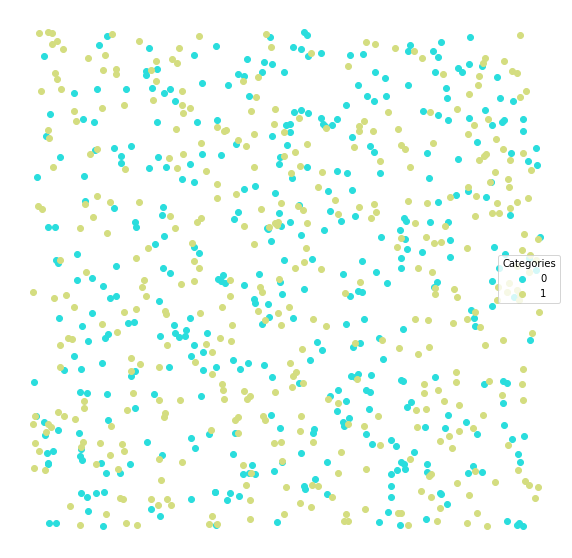

In [9]:
lucem_illud_2020.plotter(dfTrain)

## Training a Machine Learning algorithm 訓練機器學習算法

We can now pick a model, there are many more options in `scikit-learn`. These are just a few examples, which array along the machine learning "tribes" described in Pedro Domingos _The Master Algorithm_.

Uncomment (remove the # in front of) each algorithm one at a time, then run the cell and subsequent cells to evaluate how it learns to understand the data.

我們現在可以選擇一個模型，scikit-learn 中有更多的選項。這些只是幾個例子，它們沿著 Pedro Domingos The Master Algorithm 中描述的機器學習“部落”排列。

一次取消註釋（刪除前面的#）每個算法，然後運行單元格和後續單元格以評估它如何學習理解數據。

Scikit-learn（sklearn）是機器學習中常用的第三方模組，對常用的機器學習方法進行了封裝，包括回歸（Regression）、降維（Dimensionality Reduction）、分類（Classfication）、聚類（Clustering）等方法。 當我們面臨機器學習問題時，便可根據下圖來選擇相應的方法。

[Python之Sklearn使用教程](https://blog.csdn.net/XiaoYi_Eric/article/details/79952325)

[sklearn.neighbors.KNeighborsClassifier API說明含參數](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html)
Classifier implementing the k-nearest neighbors vote.

[機器學習：KNN分類演算法！](https://ithelp.ithome.com.tw/articles/10197110)
使用KNeighbors分類法


In [10]:
#Bayes
#clf = sklearn.naive_bayes.GaussianNB()

#Analogizes
#clf = sklearn.svm.SVC(kernel = 'linear', probability = True) #slow, set probability = False to speed up
#clf = sklearn.svm.SVC(kernel = 'poly', degree = 3, probability = True) #slower
clf = sklearn.neighbors.KNeighborsClassifier(5, weights='distance')# k, 'distance' or 'uniform'

#Classical Regression
#clf = sklearn.linear_model.LogisticRegression()

#Symbolists
#clf = sklearn.tree.DecisionTreeClassifier()
#clf = sklearn.ensemble.RandomForestClassifier()

#Connectionists
#clf = sklearn.neural_network.MLPClassifier()

#Ensemble
#clf = sklearn.ensemble.GradientBoostingClassifier()

We're using sklearn here. What is sklearn? It's an open source machine learning library for Python. We use sklearn because it features various machine learning algorithms and it works well with NumPy library. You don't need to understand the sklearn package in detail for the moment, but let's see what methods and attributes sklearn has, because we're going to use some of them:

我們可以輕鬆地將渲染的數據集可視化，因為它們是在二維中生成的。

讓我們看看 dfTrain，我們剛剛製作的模擬數據，是什麼樣子的

In [11]:
dir(sklearn)

['__SKLEARN_SETUP__',
 '__all__',
 '__builtins__',
 '__cached__',
 '__check_build',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 '__version__',
 '_config',
 '_distributor_init',
 '_loss',
 'base',
 'clone',
 'config_context',
 'decomposition',
 'dummy',
 'ensemble',
 'exceptions',
 'get_config',
 'linear_model',
 'logger',
 'logging',
 'metrics',
 'model_selection',
 'naive_bayes',
 'neighbors',
 'neural_network',
 'os',
 'preprocessing',
 'random',
 'set_config',
 'setup_module',
 'show_versions',
 'svm',
 'sys',
 'tree',
 'utils']

Now we fit the model by giving it our training data

In [12]:
clf.fit(np.stack(dfTrain['vect'], axis=0), dfTrain['category'])

KNeighborsClassifier(weights='distance')

Here, "stack" function is used. Why did we use stack function here? This is because dfTrain['vect'] is a sequence, while clf.fit() takes an array element. Let's see what dfTrain['vect'] looks like:

這裡使用了“stack”功能。為什麼我們在這裡使用stack函數？這是因為 dfTrain['vect'] 是一個序列，而 clf.fit() 接受一個數組元素。讓我們看看 dfTrain['vect'] 是什麼樣的：

In [13]:
dfTrain['vect']

787        [-0.9223357942252974, 0.94931621941561]
425      [-0.8770344244645625, 0.9285385436152542]
544     [0.24605821076274248, -0.5613210948991005]
422      [-0.4881999453288157, 0.2604206797329822]
738     [-0.3793610200633235, 0.46329627839196275]
                          ...                     
646       [0.7718015059882737, 0.8617213284319705]
740    [0.49160014840551836, -0.49915398222790164]
431    [-0.20018456739229373, -0.5721145881337746]
846       [0.3740735876315713, 0.1680602903411863]
856      [0.8538687941755487, -0.5015557392578347]
Name: vect, Length: 800, dtype: object

And let's see what np.stack(dfTrain['vect']) does:

In [14]:
np.stack(dfTrain['vect'])

array([[-0.92233579,  0.94931622],
       [-0.87703442,  0.92853854],
       [ 0.24605821, -0.56132109],
       ...,
       [-0.20018457, -0.57211459],
       [ 0.37407359,  0.16806029],
       [ 0.85386879, -0.50155574]])

As you can see, stack function takes a sequence of arrays (which have the same shape) and joins them along a new axis.  
如您所見，stack函數採用一系列數組（具有相同的形狀）並沿新軸連接它們。

np.stack相關範例與說明

[np.stack的用法](https://zhuanlan.zhihu.com/p/356851664)  
[numpy的stack大白話解釋](https://blog.csdn.net/qq_39998370/article/details/107441869)  
[numpy.stack最通俗的理解](https://blog.csdn.net/qq_17550379/article/details/78934529)  
[Numpy中stack()，hstack()，vstack()函數詳解](https://blog.csdn.net/csdn15698845876/article/details/73380803)  

## Algorithm evaluation 演算法評估

We can look at few measurements of each classifier's performance by using the testing set
我們可以使用測試集查看每個分類器性能的幾個測量值

In [15]:
lucem_illud_2020.evaluateClassifier(clf, dfTest)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
0,0.495,0.508521,0.534884,0.529330,0.438095
1,0.495,0.508521,0.482456,0.479317,0.578947


This lets us look at which classes do better:  
這讓我們看看哪些類做得更好：

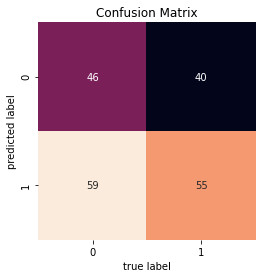

In [16]:
lucem_illud_2020.plotConfusionMatrix(clf, dfTest)

The greater the area under the curve the better.  
曲線下面積越大越好。

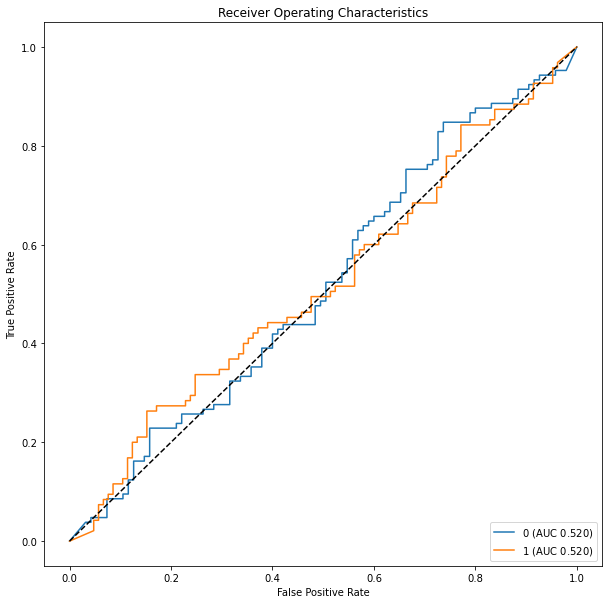

In [17]:
lucem_illud_2020.plotMultiROC(clf, dfTest)

We can also look at the regions the classifer identifies as one class or the other:

'c' 參數看起來像一個單一的數字 RGB 或 RGBA 序列，應該避免這種情況，因為如果其長度與 'x' 和 'y' 匹配，則值映射將具有優先權。如果您真的想為所有點指定相同的 RGB 或 RGBA 值，請使用單行的二維數組。
'c' 參數看起來像一個單一的數字 RGB 或 RGBA 序列，應該避免這種情況，因為如果其長度與 'x' 和 'y' 匹配，則值映射將具有優先權。如果您真的想為所有點指定相同的 RGB 或 RGBA 值，請使用單行的二維數組。

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


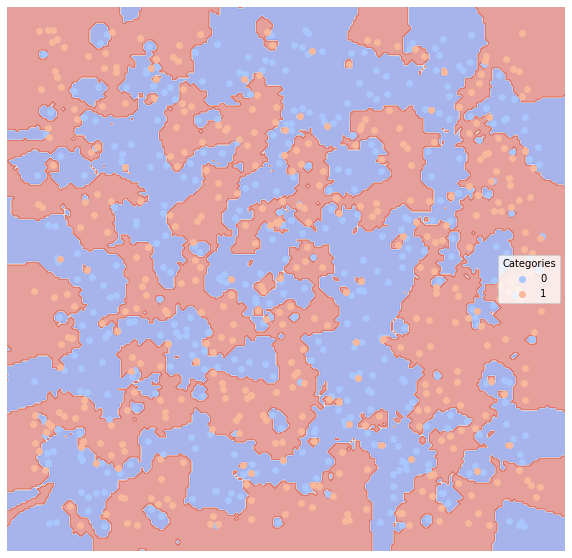

In [18]:
lucem_illud_2020.plotregions(clf, dfTrain)

## Now we do the same for real data

Available data sets include:
+ Reddit threads "classified" by thread topic
+ 20 newsgroups "classified" by group topic
+ Senate press releases "classified" by Senator (2 senators)
+ Senate press releases "classified" by Senator (5 senators)
+ Emails classified as Spam or Ham

## 現在我們對真實數據做同樣的事情

可用數據集包括:
+ Reddit 線程按主題“分類”
+ 20 個按組主題“分類”的新聞組
+ 參議院新聞稿由參議員“分類”（2 名參議員）
+ 由參議員“分類”的參議院新聞稿（5 位參議員）
+ 分類為垃圾郵件或非垃圾郵件的電子郵件

In [19]:
import sklearn.feature_extraction

+ loadReddit、loadSenateSmall、loadSenateLarge、loadSpam 會有一堆waring  
  [W108]  
  The rule-based lemmatizer did not find POS annotation for the token  
  Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
+ loadNewsGroups module 'sklearn' has no attribute 'datasets'
+
  
[解法一無用](https://stackoverflow.com/questions/66451577)： 在load加入參數 load(disable=["tagger", "ner", "lemmatizer"])
[解法二](https://stackoverflow.com/questions/53870599/disabling-part-of-the-nlp-pipeline)  

結合一+二:
修改 anaconda3\Lib\site-packages\lucem_illud_2020\proccessing.py
在spacy.load....後多加一行  
nlp.disable_pipes('lemmatizer')

新的問題出來了  
normalized_text 出來都是空的?

最後改濾掉warning的方式處理  
https://github.com/explosion/spaCy/issues/7033

In [21]:
import logging
logger = logging.getLogger("spacy")
logger.setLevel(logging.ERROR)

In [22]:
dfTrain, dfTest = lucem_illud_2020.trainTestSplit(lucem_illud_2020.loadReddit())
#dfTrain, dfTest = lucem_illud_2020.trainTestSplit(lucem_illud_2020.loadNewsGroups())
#dfTrain, dfTest = lucem_illud_2020.trainTestSplit(lucem_illud_2020.loadSenateSmall())
#dfTrain, dfTest = lucem_illud_2020.trainTestSplit(lucem_illud_2020.loadSenateLarge())
#dfTrain, dfTest = lucem_illud_2020.trainTestSplit(lucem_illud_2020.loadSpam())

Loading Reddit data
Converting to vectors


[sklearn.naive_bayes.GaussianNB API](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html)
高斯樸素貝葉斯 (GaussianNB)。  

[Scikit-learn介紹(4)_ Bayes Classification](https://ithelp.ithome.com.tw/articles/10205582)

In [23]:
dfTrain

,Unnamed: 0,author,over_18,score,subreddit,text,title,url,category,tokenized_text,normalized_text,vect
946,946,[deleted],False,163,Weeaboo Tales: stories about the extreme fans ...,"My friend told me to post this story here, I d...","Attack on dragon, AKA how I almost broke my back",https://www.reddit.com/r/weeabootales/comments...,Weeaboo Tales,"[My, friend, told, me, to, post, this, story, ...","[friend, told, post, story, know, excatly, wee...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
753,753,alexithymiaknight,False,31,Bad Roommates: Tales of Irritation,I've posted about this roommate three times an...,The organic sugar fiend wins.,https://www.reddit.com/r/badroommates/comments...,Bad Roommates,"[I, 've, posted, about, this, roommate, three,...","[ve, posted, roommate, times, ve, finally, tal...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
660,660,Twicksy,False,37,Bad Roommates: Tales of Irritation,I'm typing this as I lay awake in my room. It'...,Are you kidding me??,https://www.reddit.com/r/badroommates/comments...,Bad Roommates,"[I, 'm, typing, this, as, I, lay, awake, in, m...","[m, typing, lay, awake, room, past, hours, roo...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1582,1582,ignoranceischris,False,2096,Relationships,Link to original post: https://www.reddit.com/...,[Update post] Girlfriend [22F] coming to visit...,https://www.reddit.com/r/relationships/comment...,Relationships,"[Link, to, original, post, https://www.reddit....","[link, original, post, https://www.reddit.com/...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
619,619,afemalewhat,False,39,Bad Roommates: Tales of Irritation,So I was in a temporary living situation with ...,I've made a terrible mistake.,https://www.reddit.com/r/badroommates/comments...,Bad Roommates,"[So, I, was, in, a, temporary, living, situati...","[temporary, living, situation, relative, got, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...
335,335,Itsthejoker,False,2760,Tales From Tech Support,Background: I work as an internal helpdesk tec...,Please pick up the phone.,https://www.reddit.com/r/talesfromtechsupport/...,Tales From Tech Support,"[Background, I, work, as, an, internal, helpde...","[background, work, internal, helpdesk, technic...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
64,64,Loud-n-creepy,False,5629,Tales From Tech Support,Today everyone on our network received an e-ma...,"Turn off the computer, unplug internet cable a...",https://www.reddit.com/r/talesfromtechsupport/...,Tales From Tech Support,"[Today, everyone, on, our, network, received, ...","[today, network, received, e, mail, foreign, l...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1546,1546,tomthesouthern,False,2180,Relationships,Original Post here: https://www.reddit.com/r/r...,"UPDATE: My friends (19,20M) just humiliated me...",https://www.reddit.com/r/relationships/comment...,Relationships,"[Original, Post, here, https://www.reddit.com/...","[original, post, https://www.reddit.com/r/rela...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1418,1418,ruinedproposal,False,2577,Relationships,My girlfriend and I have been together for 6 y...,I [24M] was planning the perfect proposal to m...,https://www.reddit.com/r/relationships/comment...,Relationships,"[My, girlfriend, and, I, have, been, together,...","[girlfriend, years, know, wanting, married, wa...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [24]:
dfTest

,Unnamed: 0,author,over_18,score,subreddit,text,title,url,category,tokenized_text,normalized_text,vect
567,567,PBR_EBR,False,43,Bad Roommates: Tales of Irritation,My sophomore year in college I got two roommat...,College roommate. Has been resolved for 6 year...,https://www.reddit.com/r/badroommates/comments...,Bad Roommates,"[My, sophomore, year, in, college, I, got, two...","[sophomore, year, college, got, roommates, sam...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
267,267,Crescent-Argonian,False,3077,Tales From Tech Support,Proof you shouldn't DIY instead of leaving it ...,"You mean to tell me, you accidentally destroye...",https://www.reddit.com/r/talesfromtechsupport/...,Tales From Tech Support,"[Proof, you, should, n't, DIY, instead, of, le...","[proof, diy, instead, leaving, technician, sav...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1456,1456,DarnellTheBear,False,2414,Relationships,"Okay Reddit, lately, I've been making pretty s...",My [18 M] girlfriend [20 F] of 6 months found ...,https://www.reddit.com/r/relationships/comment...,Relationships,"[Okay, Reddit, lately, I, 've, been, making, p...","[okay, reddit, lately, ve, making, pretty, sol...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1115,1115,Hum1l1ation,False,110,Weeaboo Tales: stories about the extreme fans ...,"So I meet this cute girl, not fat, independent...",My EX(We have a lot of these stories) was a we...,https://www.reddit.com/r/weeabootales/comments...,Weeaboo Tales,"[So, I, meet, this, cute, girl, not, fat, inde...","[meet, cute, girl, fat, independent, loving, a...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
583,583,STOPTHEGUITAR,False,39,Bad Roommates: Tales of Irritation,I moved into this house about a month ago when...,Roommate plays guitar non stop. Wouldn't have ...,https://www.reddit.com/r/badroommates/comments...,Bad Roommates,"[I, moved, into, this, house, about, a, month,...","[moved, house, month, ago, friend, decided, bo...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...
201,201,Perlisforheroes,False,3431,Tales From Tech Support,"Strange things happen on eCommerce websites, a...",This is why we use test data for testing,https://www.reddit.com/r/talesfromtechsupport/...,Tales From Tech Support,"[Strange, things, happen, on, eCommerce, websi...","[strange, things, happen, ecommerce, websites,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
746,746,Curlyhairdontcaree,False,29,Bad Roommates: Tales of Irritation,"Remember my roommate, we called her Shithead. ...",Updates on the Shithead.,https://www.reddit.com/r/badroommates/comments...,Bad Roommates,"[Remember, my, roommate, we, called, her, Shit...","[remember, roommate, called, shithead, ruined,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
721,721,borupdk,False,36,Bad Roommates: Tales of Irritation,So.. my story starts approx 4 ½ months ago whe...,My psycho roommate.,https://www.reddit.com/r/badroommates/comments...,Bad Roommates,"[So, my, story, starts, approx, 4, ½, months, ...","[story, starts, approx, ½, months, ago, got, p...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
332,332,Alexander-M,False,2774,Tales From Tech Support,Long time reader and first time poster for TFT...,Your tech deleted all my documents and you nee...,https://www.reddit.com/r/talesfromtechsupport/...,Tales From Tech Support,"[Long, time, reader, and, first, time, poster,...","[long, time, reader, time, poster, tfts, long,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [25]:
#Bayes 貝葉斯
clf = sklearn.naive_bayes.GaussianNB()

#Analogizes 類比
#clf = sklearn.svm.SVC(kernel = 'linear', probability = True) #slow, set probability = False to speed up, but lose ROC
#clf = sklearn.svm.SVC(kernel = 'poly', degree = 3, probability = True) #slower
#clf = sklearn.neighbors.KNeighborsClassifier(5, weights='distance')# k, 'distance' or 'uniform'

#Classical Regression 經典回歸
#clf = sklearn.linear_model.LogisticRegression()

#Symbolists 符號？
#clf = sklearn.tree.DecisionTreeClassifier()
#clf = sklearn.ensemble.RandomForestClassifier()

#Connectionists 連結？
#clf = sklearn.neural_network.MLPClassifier()

#Ensemble
#clf = sklearn.ensemble.GradientBoostingClassifier()


fit(X, y, sample_weight=None)
Fit Gaussian Naive Bayes according to X, y.根據 X, y 擬合高斯樸素貝葉斯。

In [26]:
clf.fit(np.stack(dfTrain['vect'], axis=0), dfTrain['category'])

GaussianNB()

Classifier 分類器

In [29]:
clf.get_params()

{'priors': None, 'var_smoothing': 1e-09}

In [21]:
lucem_illud_2020.evaluateClassifier(clf, dfTest)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
Bad Roommates,0.131661,0.802538,0.753623,0.587310,0.675325
Weeaboo Tales,0.200627,0.855468,0.534351,0.521796,0.958904
Tales From Tech Support,0.072100,0.883683,0.915493,0.778987,0.792683
Relationships,0.184953,0.696839,0.791667,0.499390,0.436782


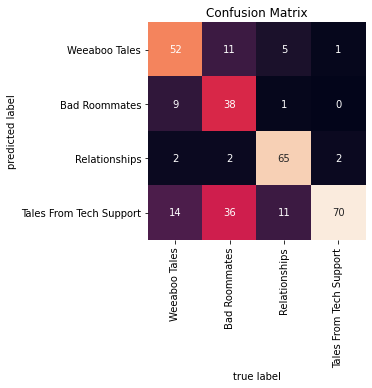

In [22]:
lucem_illud_2020.plotConfusionMatrix(clf, dfTest)

ROC曲線 (Receiver operating characteristic)  
在訊號檢測理論中，接收者操作特徵曲線是一種坐標圖式的分析工具，用於 選擇最佳的訊號偵測模型、捨棄次佳的模型。   

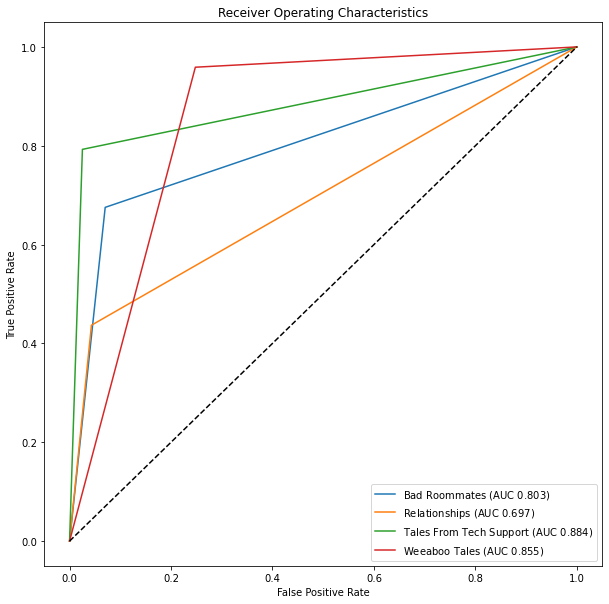

In [23]:
lucem_illud_2020.plotMultiROC(clf, dfTest)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

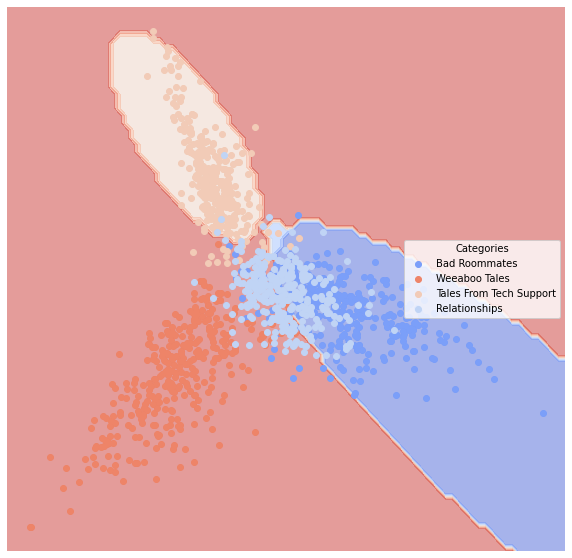

In [24]:
lucem_illud_2020.plotregions(clf, dfTrain)

## <span style="color:red">*Exercise 1*</span>

<span style="color:red">Go back through all of the cells above and generate 10 distinct artificial datasets and classify them with all of the available methods. Add a cell immediately below and describe which classifier(s) worked best with which artificially constructed data source and why. Then go through all of the empirical datasets (i.e., Newsgroups, Senate Small, Senate Large, Email Spam) and classify them with all available methods. Add a second cell immediately below and describe which classifier(s) worked best with which data set and why.  
  
<span style="color:red">返回上述所有單元格並生成 10 個不同的人工數據集，並使用所有可用方法對它們進行分類。在下面添加一個單元格並描述哪個分類器最適合哪個人工構建的數據源以及原因。然後瀏覽所有經驗數據集（即新聞組、參議院小型、參議院大型、電子郵件垃圾郵件）並使用所有可用方法對它們進行分類。在下面添加第二個單元格並描述哪個分類器最適合哪個數據集以及為什麼。
  
<span style="color:red">***Stretch*** (but also required) Wander through the SKLearn documentation available [here](http://scikit-learn.org/stable/), particularly perusing the classifiers. In cells following, identify and implement a new classifier that we have not yet used (e.g., AdaBoost, CART) on one artificial dataset and one real dataset (used above). Then, in the next cell describe the classifier, detail how it compares with the approaches above, and why it performed better or worse than others.
    
<span style="color:red">***Stretch***（但也是必需的）瀏覽[此處]((http://scikit-learn.org/stable/))提供的 SKLearn 文檔，特別是細讀分類器。在後面的單元格中，在一個人工數據集和一個真實數據集（上面使用過）上識別並實施我們尚未使用的新分類器（例如，AdaBoost、CART）。然後，在下一個單元格中描述分類器，詳細說明它如何與上述方法進行比較，以及為什麼它比其他方法表現更好或更差。

# Clinton / Obama Press Releases 柯林頓 / 歐巴馬 新聞稿

We often will not have nicely prepared data, so we will work though the proccess of cleaning and structuring in more detail here:

While the Clinton and Obama Senatorial Press Releases are not hand-coded, we can imagine that we have been given a stack of such press releases, but lost the metadata associated with which senatorial office issued which. If we label a few of them, how well can our classifier do at recovering the rest?   
  
我們通常沒有準備好的數據，所以我們將在這裡更詳細地處理清理和結構化的過程：  

雖然柯林頓和歐巴馬的參議員新聞稿不是手工編碼的，但我們可以想像，我們收到了一堆這樣的新聞稿，但丟失了與哪個參議院辦公室發布哪個相關的元數據。如果我們標記其中的一些，我們的分類器在恢復其餘部分方面做得如何？

In [25]:
ObamaClintonReleases = pandas.read_csv('../data/ObamaClintonReleases.csv', index_col=0)

I'm pretty sure that you're all familiar with pandas, but, just to clarify: why do we use pandas here? pandas is a Python library which is widely used for analyzing and wrangling data. In particular, pandas loads data and creates data frame, a Python object that looks familiar to us (since it looks like a excel table) and easy to work with. So, using pandas.read_csv function, we take in the csv file and convert it into a data frame. 

我很確定你們都熟悉熊貓，但是，只是澄清一下：為什麼我們在這裡使用熊貓？ pandas 是一個 Python 庫，廣泛用於分析和整理數據。特別是，pandas 加載數據並創建數據框，這是一個我們熟悉的 Python 對象（因為它看起來像一個 Excel 表格）並且易於使用。因此，使用 pandas.read_csv 函數，我們接收 csv 文件並將其轉換為數據框。

In [26]:
type(ObamaClintonReleases)

pandas.core.frame.DataFrame

It's a DataFrame! and it looks like this:

In [27]:
ObamaClintonReleases

,download_url,html_url,name,path,text,targetSenator
0,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,10Apr2007Obama430.txt,raw/Obama/10Apr2007Obama430.txt,Obama Calls on IRS to Protect Taxpayers ...,Obama
1,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,10Apr2008Obama108.txt,raw/Obama/10Apr2008Obama108.txt,Statement from Senator Barack Obama on the ...,Obama
2,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,10Aug2005Obama674.txt,raw/Obama/10Aug2005Obama674.txt,Obama Says Bill Will Help Cut Off Supply of...,Obama
3,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,10Aug2005Obama675.txt,raw/Obama/10Aug2005Obama675.txt,Obama Durbin Say Illinois Will Receive 33 ...,Obama
4,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,10Aug2006Obama508.txt,raw/Obama/10Aug2006Obama508.txt,Obama Introduces Bill to Help Tap Power of ...,Obama
...,...,...,...,...,...,...
1704,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,1Sep2005Clinton285.txt,raw/Clinton/1Sep2005Clinton285.txt,September 1 2005 Senator Clinton Visit Infoto...,Clinton
1705,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,1Sep2005Clinton286.txt,raw/Clinton/1Sep2005Clinton286.txt,September 1 2005 Senator Clinton Announces Ex...,Clinton
1706,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,1Sep2005Clinton287.txt,raw/Clinton/1Sep2005Clinton287.txt,September 1 2005 Senator Clinton Joins Local ...,Clinton
1707,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,1Sep2006Clinton207.txt,raw/Clinton/1Sep2006Clinton207.txt,September 1 2006 Clintons Meet with Cazenovia...,Clinton


Neat! Let's turn the 'targetSenator' column into a binary category variable.

In [28]:
ObamaClintonReleases['category'] = [s == 'Obama' for s in ObamaClintonReleases['targetSenator']]

ObamaClintonReleases['targetSenator']這個值是否等於'Obama'

In [29]:
ObamaClintonReleases['category']

0        True
1        True
2        True
3        True
4        True
        ...  
1704    False
1705    False
1706    False
1707    False
1708    False
Name: category, Length: 1709, dtype: bool

Tokenize and normalize

In [30]:
ObamaClintonReleases['tokenized_text'] = ObamaClintonReleases['text'].apply(lambda x: lucem_illud_2020.word_tokenize(x))
ObamaClintonReleases['normalized_text'] = ObamaClintonReleases['tokenized_text'].apply(lambda x: lucem_illud_2020.normalizeTokens(x))

Let's split the data into training data and testing data.

In [31]:
holdBackFraction = .2
train_data_df, test_data_df = lucem_illud_2020.trainTestSplit(ObamaClintonReleases, holdBackFraction=holdBackFraction)

In [32]:
print(len(train_data_df))
print(len(test_data_df))

1368
341


## Logistic Regression 邏輯回歸

First, let's try with a logistic regression, which may be familiar to you from statistical methods classes. First, we must turn the training dataset into a tf-idf matrix (`lucem_illud_2020.generateVecs()` will help with this but for now we are doing it the long way):

首先，讓我們嘗試使用邏輯回歸，您可能從統計方法類中熟悉它。首先，我們必須將訓練數據集轉換為 tf-idf 矩陣（lucem_illud_2020.generateVecs() 將對此有所幫助，但目前我們正在這樣做）：

In [33]:
TFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=100, min_df=2, stop_words='english', norm='l2')
TFVects = TFVectorizer.fit_transform(train_data_df['text'])

[sklearn.feature_extraction.text.TfidfVectorizer API說明](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html)  

TFVectorizer.fit_transfor 計算TFIDF矩陣
[簡單使用scikit-learn裡的TFIDF看看](https://ithelp.ithome.com.tw/articles/10228481)

The core function here is TfidfVectorizer, which takes a collection of raw documents and turn them to a tf-idf matrix. Just to recap: tf-idf means term frequency-inverse document frequency, a statistic (or, more precisely, a product of two statistics, term frequency and inverse document frequency) that shows the importance of a term vis-a-vis documents. TF, or, term frequency, counts how many times a term is used in a document; IDF, or, inverse-document-frequency, measures common or rare a term appears across documents. 
  
  
這裡的核心功能是 TfidfVectorizer，它獲取原始文檔的集合併將它們轉換為 tf-idf 矩陣。簡單回顧一下：tf-idf 表示詞頻-逆文檔頻率，這是一個統計數據（或者更準確地說，是兩個統計數據的乘積，詞頻和逆文檔頻率），它顯示了一個詞相對於文檔的重要性。 TF，或稱詞頻，計算一個詞在文檔中被使用的次數； IDF，或逆文檔頻率，測量在文檔中出現的常見或罕見術語。  


Let's look at three parameters of TfidfVectorizer: max_df = 100, min_df = 2, and norm='l2'. What do those parameters mean? 

(1) max_df = 100

Here, we specified a thredhold of 100, and the terms that have a document frequency higher than 100 would be ignored.  
在這裡，我們指定了 100 的閾值，並且文檔頻率高於 100 的術語將被忽略。

(2) min_df = 2

We specified a lower bound, 2, and the terms that have a document frequency lower than 2 will be ignored.  
我們指定了一個下限 2，文檔頻率低於 2 的詞將被忽略。

(3) norm = 'l2'

This parameter is about vector normalization. In machine learning, we commonly normalize vectors, i.e., change the length of vectors and turn them into a unit vector, before passing them into algorithms. There are various ways of normalizations, and this parameter specifies how we normalize vectors. Here, we set the norm to l2, in which case, we normalize the vectors such that squares of vector elements sums to 1. Alternatively, we can set it to l1, in which case the sum of absolute values of vector elements, not the square of vector elements, is 1.  
  
這個參數是關於向量歸一化的。在機器學習中，我們通常對向量進行歸一化，即改變向量的長度並將它們轉換為單位向量，然後再將它們傳遞給算法。有多種歸一化方法，該參數指定我們如何歸一化向量。在這裡，我們將範數設置為 l2，在這種情況下，我們將向量歸一化，使得向量元素的平方和為 1。或者，我們可以將其設置為 l1，在這種情況下，向量元素的絕對值之和，而不是向量元素的平方，是 1。

fit_transform() literally fits to data and then transform it. So, fit_transform() is just a combination of two steps--(1) fitting parameters to data; (2) then, using the vocabulary and document frequencies learned by fit(), transforming documents into document-term matrix. So, it's the same as fit followed by transform.  
fit_transform() 字面上適合數據，然後轉換它。所以，fit_transform() 只是兩個步驟的組合——(1) 將參數擬合到數據； (2) 然後，利用fit()學習到的詞彙和文檔頻率，將文檔轉化為文檔-詞條矩陣。因此，它與 fit 後跟 transform 相同。

Note that we can use the CountVectorizer instead, which simply produces a matrix of word counts.  
請注意，我們可以改用 CountVectorizer，它只生成一個字數矩陣。

In [34]:
TFVects.shape

(1368, 11327)

We can save this in the dataframe to make things easier

In [35]:
train_data_df['vect'] = [np.array(v).flatten() for v in TFVects.todense()]

np.array(v).flatten()：Return a copy of the array collapsed into one dimension.  
回傳一維Array

Looks simple, but we need to know what todense() does here. todense() returns a dense matrix representation of the matrix. Why do we need this? As you can see above, the TFVects, a document-term matrix, has 11349 columns, and this matrix is sparse, in the sense that it is comprised mostly of zeros. Dense matrices, in contrast, are the matrices that are comprised of mostly non-zeros. Then why do we make sparse matrices into dense ones? Because zero values don't contain important information but take up so much memory.  
  
看起來很簡單，但我們需要知道 todense() 在這裡做了什麼。 todense() 返回矩陣的密集矩陣表示。  
我們為什麼需要這個？正如你在上面看到的，TFVects，一個文檔項矩陣，有 11349 列，這個矩陣是稀疏的，因為它主要由零組成。  
相比之下，密集矩陣是主要由非零組成的矩陣。那為什麼我們要把稀疏矩陣變成稠密矩陣呢？因為零值不包含重要信息但佔用太多內存。

In a regression, we cannot have more variables than cases. So, we need to first do a dimension reduction. First, we will approah this with PCA. You have previously seen this in week 3. Here we are not concerned about visualization, but rather classification and so all principal components are calculated. Watch out: we have to use `stack` not `sum` for combining the vectors. We note that you could also use topic loading and embedding dimensions as featured variables.
  
在回歸中，我們不能有比案例更多的變量。所以，我們需要先做降維。首先，我們將通過 PCA 來解決這個問題。您之前已經在第 3 週看到了這一點。  
這裡我們不關心可視化，而是分類，因此計算所有主成分。注意：我們必須使用 stack 而不是 sum 來組合向量。  
我們注意到您還可以使用主題加載和嵌入維度作為特徵變量。

In [36]:
pca = sklearn.decomposition.PCA()
reduced_data = pca.fit_transform(np.stack(train_data_df['vect'], axis=0))

We can store the PCA space vectors in the dataframe too:  
我們也可以在數據幀中存儲 PCA 空間向量：

In [37]:
train_data_df['pca'] = [r for r in reduced_data]

Visualization in 2D:

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


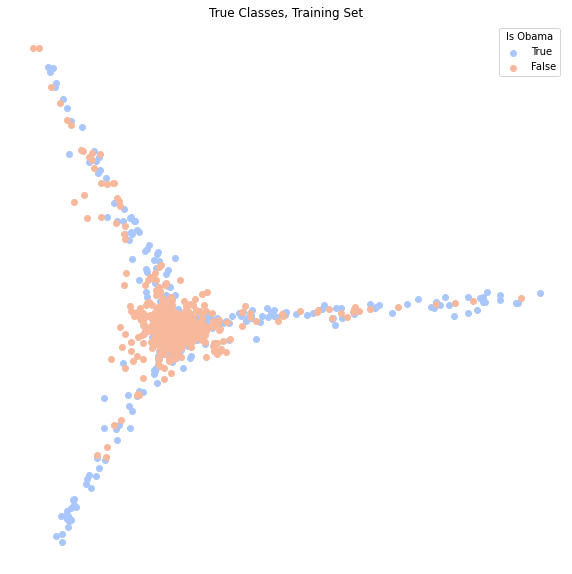

In [38]:
fig, ax = plt.subplots(figsize = (10,10))
ax.axis('off')
pallet = seaborn.color_palette(palette='coolwarm', n_colors = 2)

#Plot Obama
a = np.stack(train_data_df[train_data_df['category']]['pca'])
ax.scatter(a[:,0], a[:, 1], c = pallet[0], label = "True")

#Plot not Obama
a = np.stack(train_data_df[train_data_df['category'].eq(False)]['pca'])
ax.scatter(a[:,0], a[:, 1], c = pallet[1], label = "False")
    
ax.legend(loc = 'upper right', title = 'Is Obama')
plt.title('True Classes, Training Set')
plt.show()

PCA cannot distinguish Obama very well. Let's perform a screeplot to see how many Principal Components we need.  
PCA 無法很好地區分奧巴馬。讓我們執行一個 screeplot 來看看我們需要多少個主成分。

下面程式說明  
產生三張圖，並給定標題以及x.y軸
  
figsize = (16, 5)圖的size為 16 * 5  
sharey=True 共用y軸  
[matplotlib.pyplot.subplots的api](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.subplots.html)

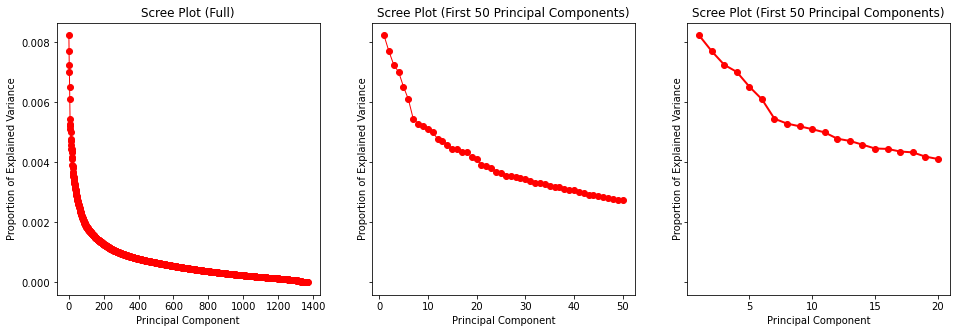

In [39]:
n = len(train_data_df)

fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize = (16, 5), sharey=True)

eigen_vals = np.arange(n) + 1
ax1.plot(eigen_vals, pca.explained_variance_ratio_, 'ro-', linewidth=1)
ax1.set_title('Scree Plot (Full)')
ax1.set_xlabel('Principal Component')
ax1.set_ylabel('Proportion of Explained Variance')

eigen_vals = np.arange(50) + 1
ax2.plot(eigen_vals, pca.explained_variance_ratio_[:50], 'ro-', linewidth=1)
ax2.set_title('Scree Plot (First 50 Principal Components)')
ax2.set_xlabel('Principal Component')
ax2.set_ylabel('Proportion of Explained Variance')


eigen_vals = np.arange(20) + 1
ax3.plot(eigen_vals, pca.explained_variance_ratio_[:20], 'ro-', linewidth=2)
ax3.set_title('Scree Plot (First 50 Principal Components)')
ax3.set_xlabel('Principal Component')
ax3.set_ylabel('Proportion of Explained Variance')

plt.show()

Let's choose the first 10 pricipal components as our covariates.  
讓我們選擇前 10 個主成分作為我們的協變量。

In [40]:
train_data_df['pca_reduced_10'] = train_data_df['pca'].apply(lambda x: x[:10])

In [41]:
train_data_df['pca_reduced_10']

1030    [-0.004017743487687969, -0.009014731343827112,...
1099    [-0.009043552243359652, -0.010905659906210974,...
1372    [-0.013545884128545946, -0.015820893977567124,...
1262    [-0.02404256767860603, 0.004576903830510011, -...
699     [-0.024181139173123464, 0.003106056093567343, ...
                              ...                        
515     [-0.1445246968140999, -0.30595210050285343, 0....
1565    [-0.005076451120531288, -0.027389641035832538,...
117     [-0.005291263527614471, -0.017438595091944994,...
1697    [0.05796798256866038, 0.002391818712223209, -0...
1331    [-0.07988331242328575, -0.03386393753938817, 0...
Name: pca_reduced_10, Length: 1368, dtype: object

In [42]:
train_data_df['pca'].head(10)

1030    [-0.004017743487687969, -0.009014731343827112,...
1099    [-0.009043552243359652, -0.010905659906210974,...
1372    [-0.013545884128545946, -0.015820893977567124,...
1262    [-0.02404256767860603, 0.004576903830510011, -...
699     [-0.024181139173123464, 0.003106056093567343, ...
316     [0.016415027263935865, -0.0019186527670136853,...
645     [-0.010687187519617643, 0.004347953532478954, ...
927     [-0.004576193072805137, -0.003949551952052904,...
278     [-0.20911873870017925, 0.4717321494784894, 0.2...
1468    [-0.005568776098959962, -0.021257963988030704,...
Name: pca, dtype: object

Now we fit a logistic regression to our data.  
現在我們對我們的數據進行邏輯回歸。

建立複迴歸模型 使用 sklearn.linear_model.LogisticRegression()
[sklearn.linear_model.LogisticRegression api說明](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)

In [43]:
logistic = sklearn.linear_model.LogisticRegression()
logistic.fit(np.stack(train_data_df['pca_reduced_10'], axis=0), train_data_df['category'])

LogisticRegression()

Let's see how the logistic regression performs on the training dataset from which we develop the model. Unfortunately, the mean accuracy is only about 64%.  
讓我們看看邏輯回歸如何在我們開發模型的訓練數據集上執行。不幸的是，平均準確率只有 64% 左右。

In [44]:
logistic.score(np.stack(train_data_df['pca_reduced_10'], axis=0), train_data_df['category'])

0.6747076023391813

How does it perform on the testing dataset, which we "held out" and did not use for model training? We need to repeat all the steps on the testing data, but without retraining:  
它在測試數據集上的表現如何，我們“堅持”並沒有用於模型訓練？我們需要對測試數據重複所有步驟，但無需重新訓練：

TFVectorizer.fit_transfor 計算TFIDF矩陣  
#pca = sklearn.decomposition.PCA()
設定值


In [45]:
#Create vectors
TFVects_test = TFVectorizer.transform(test_data_df['text'])
test_data_df['vect'] = [np.array(v).flatten() for v in TFVects_test.todense()]

#PCA
reduced_data_test = pca.transform(np.stack(test_data_df['vect'], axis=0))
test_data_df['pca'] = [r for r in reduced_data_test]
test_data_df['pca_reduced_10'] = test_data_df['pca'].apply(lambda x: x[:10])

#Test
logistic.score(np.stack(test_data_df['pca_reduced_10'], axis=0), test_data_df['category'])

0.6129032258064516

Slightly poorer. How about using more dimensions (40)?  
差一點。使用更多維度 (40) 怎麼樣？

In [46]:
train_data_df['pca_reduced_40'] = train_data_df['pca'].apply(lambda x: x[:40])
test_data_df['pca_reduced_40'] = test_data_df['pca'].apply(lambda x: x[:40])

logistic.fit(np.stack(train_data_df['pca_reduced_40'], axis=0), train_data_df['category'])

print("Training:")
print(logistic.score(np.stack(train_data_df['pca_reduced_40'], axis=0), train_data_df['category']))
print("Testing:")
print(logistic.score(np.stack(test_data_df['pca_reduced_40'], axis=0), test_data_df['category']))

Training:
0.7273391812865497
Testing:
0.6744868035190615


Or still more (100)?

In [47]:
train_data_df['pca_reduced_100'] = train_data_df['pca'].apply(lambda x: x[:100])
test_data_df['pca_reduced_100'] = test_data_df['pca'].apply(lambda x: x[:100])

logistic.fit(np.stack(train_data_df['pca_reduced_100'], axis=0), train_data_df['category'])

print("Training:")
print(logistic.score(np.stack(train_data_df['pca_reduced_100'], axis=0), train_data_df['category']))
print("Testing:")
print(logistic.score(np.stack(test_data_df['pca_reduced_100'], axis=0), test_data_df['category']))

Training:
0.831140350877193
Testing:
0.7536656891495601


Or even more (200)!

In [48]:
train_data_df['pca_reduced_200'] = train_data_df['pca'].apply(lambda x: x[:200])
test_data_df['pca_reduced_200'] = test_data_df['pca'].apply(lambda x: x[:200])

logistic.fit(np.stack(train_data_df['pca_reduced_200'], axis=0), train_data_df['category'])

print("Training:")
print(logistic.score(np.stack(train_data_df['pca_reduced_200'], axis=0), train_data_df['category']))
print("Testing:")
print(logistic.score(np.stack(test_data_df['pca_reduced_200'], axis=0), test_data_df['category']))

Training:
0.8735380116959064
Testing:
0.7888563049853372


This is becoming ridiculous (400)!

In [49]:
train_data_df['pca_reduced_400'] = train_data_df['pca'].apply(lambda x: x[:400])
test_data_df['pca_reduced_400'] = test_data_df['pca'].apply(lambda x: x[:400])

logistic.fit(np.stack(train_data_df['pca_reduced_400'], axis=0), train_data_df['category'])

print("Training:")
print(logistic.score(np.stack(train_data_df['pca_reduced_400'], axis=0), train_data_df['category']))
print("Testing:")
print(logistic.score(np.stack(test_data_df['pca_reduced_400'], axis=0), test_data_df['category']))

Training:
0.9159356725146199
Testing:
0.7947214076246334


Increasing the number of covariates would overfit our data, and it seems that using a logistic regression, our prediction accuracy is at best about 65%. We can, however, try a logistic regression that uses the TF-IDF scores for each word, but with an L1 regularization or L1-norm loss function, which is also known as least absolute deviations (LAD), least absolute errors (LAE) or L1 penalty. It minimizes the sum of the absolute differences (S) between the target value ($Y_i$) and the estimated values ($f(x_i)$) and prunes all insignificant variables (i.e., word TF-IDF scores):

$S=\sum^n_{i=1}|y_i=f(x_i)|$

The result is a model retaining only the most individually significant features.

增加協變量的數量會過度擬合我們的數據，似乎使用邏輯回歸，我們的預測準確率最多約為 65%。但是，我們可以嘗試對每個單詞使用 TF-IDF 分數的邏輯回歸，但使用 L1 正則化或 L1 範數損失函數，也稱為最小絕對偏差 (LAD)、最小絕對誤差 (LAE)或 L1 懲罰。它最小化目標值 () 和估計值 () 之間的絕對差 (S) 的總和，並修剪所有無關緊要的變量（即單詞 TF-IDF 分數）：

$S=\sum^n_{i=1}|y_i=f(x_i)|$

結果是模型只保留了最個別重要的特徵。

In [50]:
logistic_l1= sklearn.linear_model.LogisticRegression(penalty='l2')
logistic_l1.fit(np.stack(train_data_df['vect'], axis=0), train_data_df['category'])
print(logistic_l1.score(np.stack(train_data_df['vect'], axis=0), train_data_df['category']))

0.9568713450292398


Train the model using training data, and then test it on the testing data.  
使用訓練數據訓練模型，然後在測試數據上進行測試。

In [51]:
print(logistic_l1.score(np.stack(test_data_df['vect'], axis=0), test_data_df['category']))

0.8123167155425219


81% accuracy seems like the best we can get by using a logistic regression.  
81% 的準確率似乎是我們使用邏輯回歸所能得到的最好結果。

Now let's try with Naive Bayes. Classically, it is trained with word counts, but TF-IDF vectors are also quite good:  
現在讓我們嘗試單純貝氏。傳統上，它是用字數訓練的，但 TF-IDF 向量也相當不錯：

[sklearn.naive_bayes.BernoulliNB api說明](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.BernoulliNB.html)  
  
[[第7天]單純貝氏分類器(Naive Bayes)](https://ithelp.ithome.com.tw/articles/10200078)  
共有四篇

In [52]:
naiveBayes = sklearn.naive_bayes.BernoulliNB()
naiveBayes.fit(np.stack(train_data_df['vect'], axis=0), train_data_df['category'])

BernoulliNB()

In [54]:
print("Training:")
print(naiveBayes.score(np.stack(train_data_df['vect'], axis=0), train_data_df['category']))
print("Testing:")
print(naiveBayes.score(np.stack(test_data_df['vect'], axis=0), test_data_df['category']))

Training:
0.9641812865497076
Testing:
0.8533724340175953


A bit better than the logit, but that's just looking at the accuracy. What about other measures? Let's first save the predictions in the dataframe to save use rerunning the model every time:  
比 logit 好一點，但這只是看準確性。其他措施呢？讓我們首先將預測保存在數據框中，以節省每次重新運行模型的使用：

In [55]:
test_data_df['nb_predict'] = naiveBayes.predict(np.stack(test_data_df['vect'], axis=0))
test_data_df['nb_predict_prob_true'] = naiveBayes.predict_proba(np.stack(test_data_df['vect'], axis=0))[:,0] #other is prop false

使用sklearn.metric的評估機器學習演算方法
[表現的評估](https://yaojenkuo.io/ml-newbies/07-performance.html)

Precision:  
精確

In [56]:
sklearn.metrics.precision_score(test_data_df['category'], test_data_df['nb_predict'])

0.8602941176470589

Recall:  
召回

In [57]:
sklearn.metrics.recall_score(test_data_df['category'], test_data_df['nb_predict'])

0.7905405405405406

F1-measure:

In [58]:
sklearn.metrics.f1_score(test_data_df['category'], test_data_df['nb_predict'])

0.823943661971831

Let's take a look at how well our posterior distribution looks relative to the truth.  
讓我們來看看我們的後驗分佈相對於事實的表現如何。

In [59]:
test_data_df['category'].eq(True)

80       True
123      True
466      True
546      True
296      True
        ...  
1639    False
1178    False
1679    False
413      True
433      True
Name: category, Length: 341, dtype: bool

In [60]:
test_data_df[test_data_df['category'].eq(True)]['nb_predict_prob_true']

80     3.485667e-18
123    2.941211e-03
466    2.612141e-16
546    1.635792e-01
296    3.585834e-01
           ...     
30     4.552327e-20
436    3.102024e-12
583    4.415021e-10
413    2.327433e-17
433    2.202470e-03
Name: nb_predict_prob_true, Length: 148, dtype: float64

pandas.DataFrame.hist：制作DataFrame的直方圖  
在統計學中，直方圖是一種對數據分布情況的圖形表示，是一種二維統計圖表
[【数据可视化】Pandas画直方图](https://blog.csdn.net/ChenVast/article/details/81563561)  
bins 分幾條直方

In [62]:
test_data_df.head(5)

,download_url,html_url,name,path,text,targetSenator,category,tokenized_text,normalized_text,vect,pca,pca_reduced_10,pca_reduced_40,pca_reduced_100,pca_reduced_200,pca_reduced_400,nb_predict,nb_predict_prob_true
80,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,13Oct2005Obama638.txt,raw/Obama/13Oct2005Obama638.txt,Obama Coburn Say Suspicious Katrina Contra...,Obama,True,"[Obama, Coburn, Say, Suspicious, Katrina, Cont...","[obama, coburn, suspicious, katrina, contract,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.04569783057870478, 0.11155132684471131, 0....","[-0.04569783057870478, 0.11155132684471131, 0....","[-0.04569783057870478, 0.11155132684471131, 0....","[-0.04569783057870478, 0.11155132684471131, 0....","[-0.04569783057870478, 0.11155132684471131, 0....","[-0.04569783057870478, 0.11155132684471131, 0....",True,3.485667e-18
123,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,15Mar2007Obama446.txt,raw/Obama/15Mar2007Obama446.txt,Obama Statement on Senate Vote Blocking Tro...,Obama,True,"[Obama, Statement, on, Senate, Vote, Blocking,...","[obama, statement, senate, vote, block, troop,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.0025335439883168755, -0.0241819631246108, ...","[-0.0025335439883168755, -0.0241819631246108, ...","[-0.0025335439883168755, -0.0241819631246108, ...","[-0.0025335439883168755, -0.0241819631246108, ...","[-0.0025335439883168755, -0.0241819631246108, ...","[-0.0025335439883168755, -0.0241819631246108, ...",True,2.941211e-03
466,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,27Sep2007Obama267.txt,raw/Obama/27Sep2007Obama267.txt,Senator Obama Statement on Burma U S Sen...,Obama,True,"[Senator, Obama, Statement, on, Burma, U, S, S...","[senator, obama, statement, burma, u, s, senat...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.004278009344789662, -0.006283424681189392,...","[-0.004278009344789662, -0.006283424681189392,...","[-0.004278009344789662, -0.006283424681189392,...","[-0.004278009344789662, -0.006283424681189392,...","[-0.004278009344789662, -0.006283424681189392,...","[-0.004278009344789662, -0.006283424681189392,...",True,2.612141e-16
546,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,30Mar2007Obama433.txt,raw/Obama/30Mar2007Obama433.txt,Obama Renews Call for Gonzales to be Replac...,Obama,True,"[Obama, Renews, Call, for, Gonzales, to, be, R...","[obama, renew, gonzale, replace, attorney, gen...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0057794743047211924, -0.008857712157903765,...","[0.0057794743047211924, -0.008857712157903765,...","[0.0057794743047211924, -0.008857712157903765,...","[0.0057794743047211924, -0.008857712157903765,...","[0.0057794743047211924, -0.008857712157903765,...","[0.0057794743047211924, -0.008857712157903765,...",True,1.635792e-01
296,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,21Jul2005Obama690.txt,raw/Obama/21Jul2005Obama690.txt,Obama Says Technology Key to Cutting Health...,Obama,True,"[Obama, Says, Technology, Key, to, Cutting, He...","[obama, say, technology, key, cut, health, car...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.01622797266697485, -0.025532344120233898, -...","[0.01622797266697485, -0.025532344120233898, -...","[0.01622797266697485, -0.025532344120233898, -...","[0.01622797266697485, -0.025532344120233898, -...","[0.01622797266697485, -0.025532344120233898, -...","[0.01622797266697485, -0.025532344120233898, -...",True,3.585834e-01


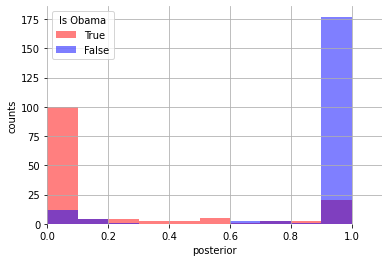

In [48]:
fig, ax = plt.subplots()
ax.grid(False)
ax.set_frame_on(False)
test_data_df[test_data_df['category'].eq(True)]['nb_predict_prob_true'].hist(alpha = 0.5, ax = ax, bins = 10, label = 'True', color = 'red')
test_data_df[test_data_df['category'].eq(False)]['nb_predict_prob_true'].hist(alpha = 0.5, ax = ax, bins = 10, label = 'False', color = 'blue')
ax.set_xlim((0,1.1))
ax.legend(title = "Is Obama")
ax.set_xlabel('posterior')
ax.set_ylabel('counts')
plt.show()

The classification is suprisingly accurate. We can even look at what words are most influential with a bit of simple math:  
分類出奇的準確。我們甚至可以通過一些簡單的數學來看看哪些詞最有影響力：

In [63]:
naiveBayes

BernoulliNB()

In [64]:
naiveBayes.feature_log_prob_

array([[-5.30950456, -6.00265174, -5.59718663, ..., -4.61635738,
        -5.59718663, -5.59718663],
       [-4.38736948, -4.94698527, -6.33327963, ..., -4.54152016,
        -6.33327963, -6.33327963]])

In [65]:
tVals, fVals = naiveBayes.feature_log_prob_

In [66]:
tVals

array([-5.30950456, -6.00265174, -5.59718663, ..., -4.61635738,
       -5.59718663, -5.59718663])

In [67]:
fVals

array([-4.38736948, -4.94698527, -6.33327963, ..., -4.54152016,
       -6.33327963, -6.33327963])

In [68]:
#Top indices
trueVals, falseVals = naiveBayes.feature_log_prob_

words_dict = {
    'Obama' : [],
    'Obama_log_prob' : [],
    'Clinton' : [],
    'Clinton_log_prob' : [],
}

for i, prob in sorted(enumerate(trueVals), key = lambda x:x[1], reverse=True)[:15]:
    words_dict['Obama'].append(TFVectorizer.get_feature_names()[i])
    words_dict['Obama_log_prob'].append(prob)

for i, prob in sorted(enumerate(falseVals), key = lambda x:x[1], reverse=True)[:15]:
    words_dict['Clinton'].append(TFVectorizer.get_feature_names()[i])
    words_dict['Clinton_log_prob'].append(prob)
    
pandas.DataFrame(words_dict)

,Obama,Obama_log_prob,Clinton,Clinton_log_prob
0,welcomed,-2.253148,5566,-1.718159
1,ground,-2.378311,labolt,-1.728109
2,urging,-2.378311,amy,-1.789985
3,class,-2.391734,brundage,-1.878932
4,urban,-2.391734,dick,-1.878932
5,growing,-2.433119,monday,-1.890628
6,entire,-2.447304,chicago,-2.002546
7,construction,-2.461692,reform,-2.190145
8,enable,-2.461692,location,-2.272837
9,environment,-2.461692,practices,-2.272837


## Multinomial Naive Bayes 多項式單純貝葉斯/貝氏

What if we want to classify our text into one of *many* classes? The multinomial Naive Bayes generating model assumes that document features (e.g., words) are generated by draws from a multinomial distribution (recall this gives the probability to observe a particular pattern of counts across features). 

Let's explore this using the 20NG dataset, a scikit learn built in dataset which features 20 news categories.

如果我們想將我們的文本分類為許多類之一怎麼辦？多項樸素貝葉斯生成模型假設文檔特徵（例如，單詞）  
是通過從多項分佈中抽取生成的（回想一下，這給出了觀察特徵之間特定計數模式的概率）。  
  
讓我們使用 20NG 數據集探索這一點，這是一個 scikit learn 內置數據集，具有 20 個新聞類別。

[sklearn.datasets.fetch_20newsgroups api說明](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_20newsgroups.html)  

會去讀取這個檔案 20news-bydate_py3.pkz

In [69]:
from sklearn import datasets

In [70]:
newsgroups = sklearn.datasets.fetch_20newsgroups(data_home = '../data') #Free data to play with: documents from a newsgroup corpus.
newsgroups.target_names #Possible categories, i.e., the newsgroups

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

We can pick specific categories, and pull the relevant training and testing sets. 

In [71]:
target_categories = ['talk.religion.misc', 'soc.religion.christian', 'sci.space', 'comp.graphics'] #Can change these of course

newsgroupsDF = pandas.DataFrame(columns = ['text', 'category', 'source_file'])
for category in target_categories:
    print("Loading data for: {}".format(category))
    ng = sklearn.datasets.fetch_20newsgroups(categories = [category], remove=['headers', 'footers', 'quotes'], data_home = '../data')
    newsgroupsDF = newsgroupsDF.append(pandas.DataFrame({'text' : ng.data, 'category' : [category] * len(ng.data), 'source_file' : ng.filenames}), ignore_index=True)

Loading data for: talk.religion.misc
Loading data for: soc.religion.christian
Loading data for: sci.space
Loading data for: comp.graphics


Now we need to tokenize, and make a training and testing set:

In [72]:
newsgroupsDF

,text,category,source_file
0,\n\nParadise and salvation are not the same th...,talk.religion.misc,../data/20news_home/20news-bydate-train/talk.r...
1,\nYou're admitting a lot more than that. You ...,talk.religion.misc,../data/20news_home/20news-bydate-train/talk.r...
2,"\n\nJesus also recognized other holy days, lik...",talk.religion.misc,../data/20news_home/20news-bydate-train/talk.r...
3,In <lsjc8cINNmc1@saltillo.cs.utexas.edu> turpi...,talk.religion.misc,../data/20news_home/20news-bydate-train/talk.r...
4,"\nI'm sorry, but He does not! Ever read the F...",talk.religion.misc,../data/20news_home/20news-bydate-train/talk.r...
...,...,...,...
2148,This article was probably generated by a buggy...,comp.graphics,../data/20news_home/20news-bydate-train/comp.g...
2149,Hi all!\n\tI've just recently become seriously...,comp.graphics,../data/20news_home/20news-bydate-train/comp.g...
2150,Hi !!! This is the response for Wayne Michael....,comp.graphics,../data/20news_home/20news-bydate-train/comp.g...
2151,I was recently talking to a possible employer ...,comp.graphics,../data/20news_home/20news-bydate-train/comp.g...


In [73]:
newsgroupsDF['tokenized_text'] = newsgroupsDF['text'].apply(lambda x: lucem_illud_2020.word_tokenize(x))
newsgroupsDF['normalized_text'] = newsgroupsDF['tokenized_text'].apply(lambda x: lucem_illud_2020.normalizeTokens(x))

In [74]:
holdBackFraction = .2
train_ng_df, test_ng_df = lucem_illud_2020.trainTestSplit(newsgroupsDF, holdBackFraction=holdBackFraction)

In [75]:
print(len(train_ng_df))
print(len(test_ng_df))

1723
430


We need to extract features from the text. We can use built-in feature extraction to do so. We will use a tf-idf vectorizer, which converts the document into a vector of words with tf-idf weights (term-frequency inverse-document frequency). This gives high weight to words that show up a lot in a given document, but rarely across documents in the corpus (more distinctive).   
  
我們需要從文本中提取特徵。我們可以使用內置的特徵提取來做到這一點。  
我們將使用 tf-idf 向量化器，它將文檔轉換為具有 tf-idf 權重（詞頻逆文檔頻率）的詞向量。  
這對在給定文檔中出現很多但很少在語料庫中的文檔中出現的單詞給予了很高的權重（更獨特）。

In [76]:
TFVectorizer_ng = sklearn.feature_extraction.text.TfidfVectorizer(max_df=100, min_df=2, stop_words='english', norm='l2')
TFVects_ng = TFVectorizer_ng.fit_transform(train_ng_df['text'])
train_ng_df['vect'] = [np.array(v).flatten() for v in TFVects_ng.todense()]

Now we can train the model:  
現在我們可以訓練模型：

In [77]:
train_ng_df['vect']

1685    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
544     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
1693    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0389551070647516, ...
156     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
695     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
                              ...                        
1448    [0.0, 0.028849515991257072, 0.0, 0.01638351146...
342     [0.0, 0.17336018765601224, 0.0, 0.0, 0.0, 0.0,...
235     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
1147    [0.0, 0.0, 0.0, 0.023236288591387787, 0.0, 0.0...
1183    [0.0, 0.11019737497039465, 0.0, 0.0, 0.0, 0.0,...
Name: vect, Length: 1723, dtype: object

In [78]:
MultinomialNB_ng = sklearn.naive_bayes.MultinomialNB()
MultinomialNB_ng.fit(np.stack(train_ng_df['vect'], axis = 0), train_ng_df['category'])

MultinomialNB()

...and save predictions to the dataframe:  
...並將預測保存到數據框：

In [79]:
train_ng_df['nb_predict'] = MultinomialNB_ng.predict(np.stack(train_ng_df['vect'], axis=0))
print("Training score:")
print(MultinomialNB_ng.score(np.stack(train_ng_df['vect'], axis=0), train_ng_df['category']))

Training score:
0.9042367962855484


In [59]:
train_ng_df[['category', 'nb_predict']][:10]

,category,nb_predict
897,soc.religion.christian,soc.religion.christian
570,soc.religion.christian,soc.religion.christian
1659,comp.graphics,comp.graphics
515,soc.religion.christian,soc.religion.christian
381,soc.religion.christian,soc.religion.christian
1859,comp.graphics,comp.graphics
1107,sci.space,sci.space
1861,comp.graphics,comp.graphics
742,soc.religion.christian,soc.religion.christian
1067,sci.space,sci.space


Looks pretty good, lets examine the testing dataset:  
看起來不錯，讓我們檢查測試數據集：

In [80]:
#Create vectors
TFVects_test = TFVectorizer_ng.transform(test_ng_df['text'])
test_ng_df['vect'] = [np.array(v).flatten() for v in TFVects_test.todense()]

#Add to df
test_ng_df['nb_predict'] = MultinomialNB_ng.predict(np.stack(test_ng_df['vect'], axis=0))

#Test
print("Testing score:")
print(MultinomialNB_ng.score(np.stack(test_ng_df['vect'], axis=0), test_ng_df['category']))

Testing score:
0.8186046511627907


We can even use a confusion matrix, like we used last week for evaluating human coders relative to one another. Now we are evaluating our classifier relative to human coding.   
We'll just use the one in `lucem_illud_2020`, which requres a classifier and a dataframe with `'vect'` and `'category'` columns, like we have in the examples:

我們甚至可以使用混淆矩陣，就像我們上周用來評估人類編碼人員之間的關係一樣。現在我們正在評估相對於人類編碼的分類器。  
我們將只使用 `lucem_illud_2020` 中的那個，它需要一個分類器和一個帶有 `'vect'` 和 `'category'` 列的數據框，就像我們在示例中那樣：

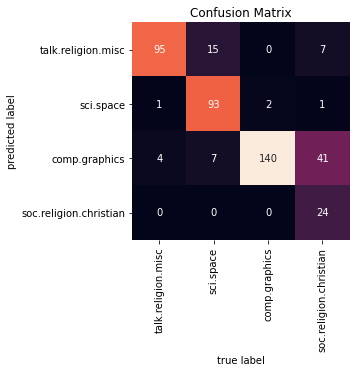

In [81]:
lucem_illud_2020.plotConfusionMatrix(MultinomialNB_ng, test_ng_df)

Let's calculate the precision, recall, and F-measures.  
讓我們計算精度、召回率和 F 度量。

In [82]:
print(sklearn.metrics.precision_score(test_ng_df['category'], test_ng_df['nb_predict'], average = 'weighted')) #precision
print(sklearn.metrics.recall_score(test_ng_df['category'], test_ng_df['nb_predict'], average = 'weighted')) #recall

0.8558046042372344
0.8186046511627907


We can evaluate these per catagory. This has the same requiments as `plotConfusionMatrix`:  
我們可以按類別評估這些。這與 `plotConfusionMatrix` 具有相同的要求：

In [83]:
lucem_illud_2020.metrics.evaluateClassifier(MultinomialNB_ng, test_ng_df)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
talk.religion.misc,0.113953,0.664384,1.000000,0.442721,0.328767
comp.graphics,0.062791,0.941667,0.811966,0.782995,0.950000
soc.religion.christian,0.125581,0.902680,0.729167,0.723548,0.985915
sci.space,0.060465,0.897999,0.958763,0.826510,0.808696


We can also plot the ROC curves. This has the same requiments as `plotConfusionMatrix`:  

我們還可以繪製 ROC 曲線。這與 `plotConfusionMatrix` 具有相同的要求：

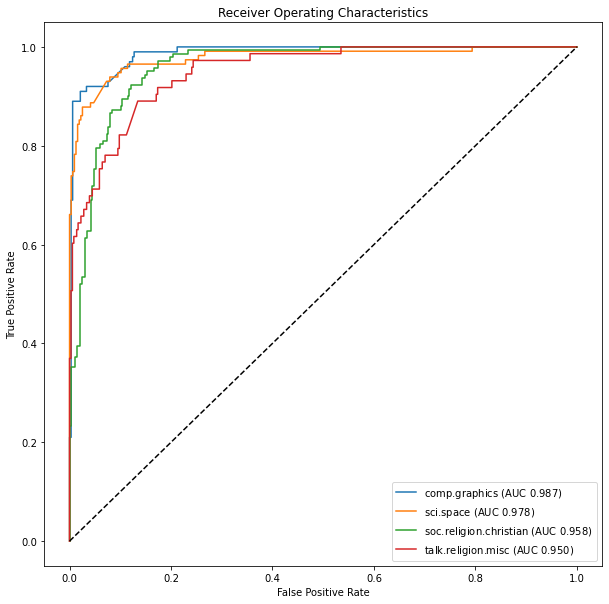

In [85]:
lucem_illud_2020.plotMultiROC(MultinomialNB_ng, test_ng_df)

And we can plot the PCA space visualization:

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

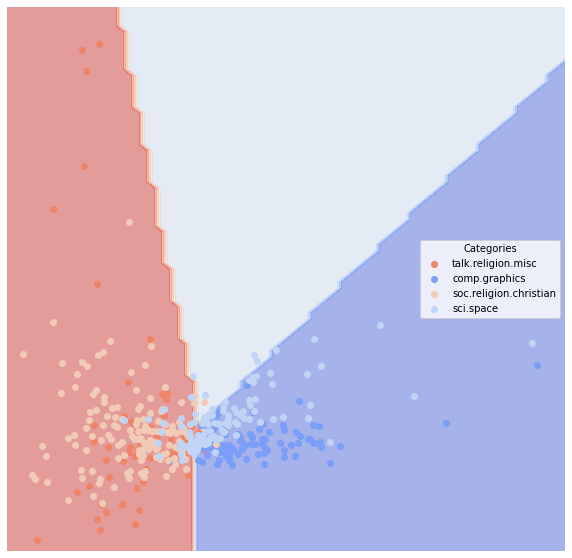

In [86]:
lucem_illud_2020.plotregions(MultinomialNB_ng, test_ng_df)

## <span style="color:red">*Exercise 2*</span>

<span style="color:red">In the cells immediately following, perform Logistic and Naïve Bayes classification (binary or multinomial) using training, testing and extrapolation (uncoded) data from texts and hand-classifications associated with your final project (e.g., these could be crowd-sourced codes gathered through Amazon Mechanical Turk last week). Visualize the confusion matrix for training and testing sets. Calculate precision, recall, the F-measure, and AUC, then perform an ROC visualization. How do these classifiers perform? Exrapolate codes from these models to all uncoded data.


## <span style="color:red">*Exercise 2*</span>

<span style="color:red">在緊隨其後的單元格中，使用來自與最終項目相關的文本和手工分類的訓練、測試和外推（未編碼）數據（例如，這些可能是通過亞馬遜機械土耳其人上週）。可視化訓練集和測試集的混淆矩陣。計算精度、召回率、F 度量和 AUC，然後執行 ROC 可視化。這些分類器的表現如何？將這些模型中的代碼推斷為所有未編碼數據。


# Decision Trees 決策樹

Decision trees can be used to predict both categorical/class labels (i.e., classification) and continuous labels (i.e., regression).  
決策樹可用於預測分類/類別標籤（即分類）和連續標籤（即回歸）。

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

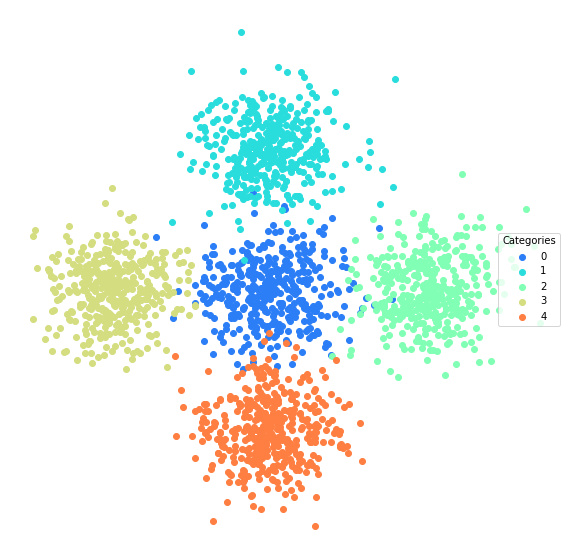

In [87]:
blobs_df = lucem_illud_2020.multiBlobs(noise=.2, centers=[(0,0), (0,5), (5,0), (-5,0), (0,-5)])
df_exampleTree_train, df_exampleTree_test = lucem_illud_2020.trainTestSplit(blobs_df)
lucem_illud_2020.plotter(df_exampleTree_train)

Now we import our Decision Tree classifier from sklearn.tree (familiar syntax) and fit it using the fit method.

In [88]:
clf_tree = sklearn.tree.DecisionTreeClassifier(max_depth=4,random_state=0)
clf_tree.fit(np.stack(df_exampleTree_train['vect'], axis =0), df_exampleTree_train['category'])

DecisionTreeClassifier(max_depth=4, random_state=0)

To see what's going on visually with the classification: 

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

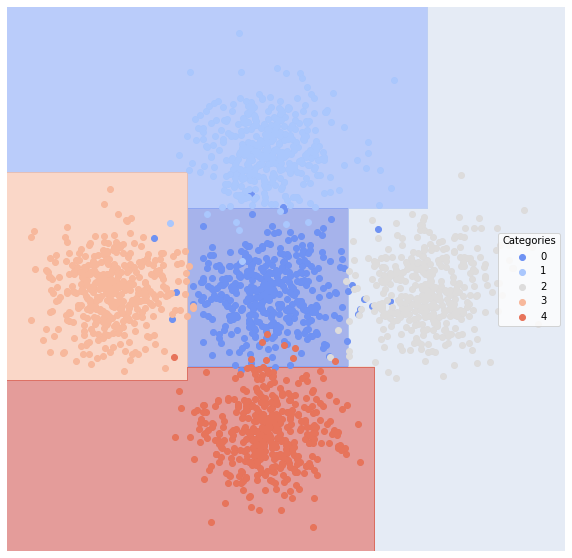

In [89]:
lucem_illud_2020.plotregions(clf_tree, df_exampleTree_train)

In [90]:
lucem_illud_2020.evaluateClassifier(clf_tree, df_exampleTree_test)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
0,0.030,0.957310,0.908163,0.862806,0.936842
1,0.008,0.981651,1.000000,0.971303,0.963303
2,0.010,0.987599,0.974790,0.962268,0.983051
3,0.004,0.993165,0.988764,0.979654,0.988764
4,0.012,0.979496,0.966292,0.939720,0.966292


Lets look at accuracy:

In [91]:
sklearn.metrics.accuracy_score(df_exampleTree_test['category'],clf_tree.predict(np.stack(df_exampleTree_test['vect'], axis = 0)))

0.968

What happens if we trim the tree?

散佈圖 plt.scatter
[Scatter plot](https://matplotlib.org/stable/gallery/shapes_and_collections/scatter.html)  
不同深度的的結果從1-20

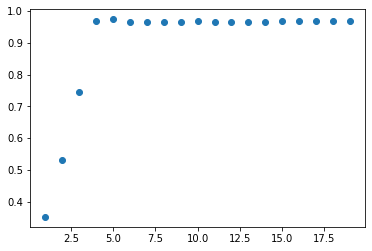

In [92]:
depthvec = []
scorevec = []
for i in range(1,20):
    tree2 = sklearn.tree.DecisionTreeClassifier(max_depth=i,random_state=0)
    tree2.fit(np.stack(df_exampleTree_train['vect'], axis =0), df_exampleTree_train['category'])
    score = sklearn.metrics.accuracy_score(df_exampleTree_test['category'], tree2.predict(np.stack(df_exampleTree_test['vect'], axis = 0)))
    depthvec.append(i)
    scorevec.append(score)
plt.scatter(depthvec,scorevec)
plt.show()

We can select different layers of the decision tree or "prune" it. At approximately four layers down in the decision tree, the shape is somewhat odd, suggesting that our model is overfitting beyond those four layers.  
我們可以選擇決策樹的不同層或“修剪”它。在決策樹下面大約四層，形狀有些奇怪，表明我們的模型在這四層之外過度擬合。

Combining multiple overfitting estimators turns out to be a key idea in machine learning. This is called **bagging** and is a type of **ensemble** method. The idea is to make many randomized estimators--each can overfit, as decision trees are wont to do--but then to combine them, ultimately producing a better classification. A **random forest** is produced by bagging decision trees.

結合多個過擬合估計器被證明是機器學習中的一個關鍵思想。這稱為 **bagging**，是一種 **ensemble** 方法。這個想法是製作許多隨機估計器——每個估計器都可能過擬合，因為決策樹通常不會這樣做——然後將它們組合起來，最終產生更好的分類。 **隨機森林**是通過裝袋決策樹產生的。

In [93]:
tree = sklearn.tree.DecisionTreeClassifier(max_depth=10) #Create an instance of our decision tree classifier.

bag = sklearn.ensemble.BaggingClassifier(tree, n_estimators=100, max_samples=0.8, random_state=1) 
#Each tree uses up to 80% of the data

In [94]:
bag.fit(np.stack(df_exampleTree_train['vect'], axis =0), df_exampleTree_train['category']) 
#Fit the bagged classifier

BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=10),
                  max_samples=0.8, n_estimators=100, random_state=1)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

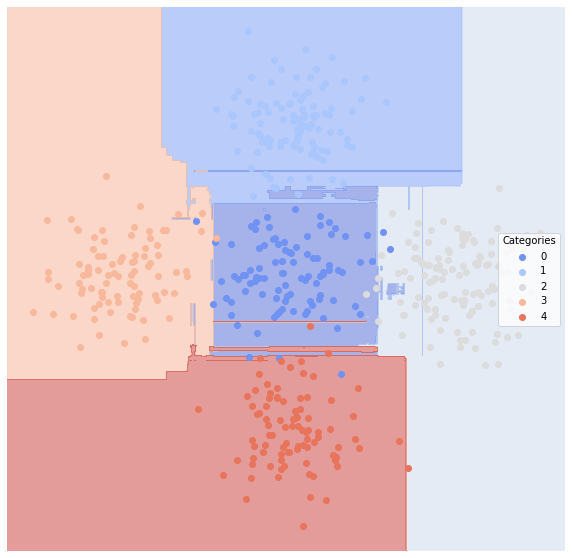

In [95]:
lucem_illud_2020.plotregions(bag, df_exampleTree_test)

In [96]:
lucem_illud_2020.evaluateClassifier(bag, df_exampleTree_test)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
0,0.028,0.954516,0.926316,0.872061,0.926316
1,0.002,0.995413,1.000000,0.992826,0.990826
2,0.012,0.983361,0.974576,0.955799,0.974576
3,0.006,0.991949,0.977778,0.968792,0.988764
4,0.012,0.979496,0.966292,0.939720,0.966292


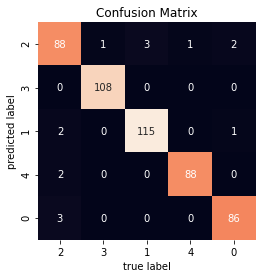

In [97]:
lucem_illud_2020.plotConfusionMatrix(bag, df_exampleTree_test)

## <span style="color:red">*Exercise 3*</span>

<span style="color:red">In the cells immediately following, perform decision tree and random forest classification (binary, multinomial or continuous) using training, testing and extrapolation (uncoded) data from texts and hand-classifications associated with your final project. As with ***Exercise 2***, these could be crowd-sourced codes gathered through Amazon Mechanical Turk last week. Visualize the classification of data points. Calculate relevant metrics (e.g., precision, recall, the F-measure, and AUC). Now build an ensemble classifier by bagging trees into a random forest. Visualize the result. How do these classifiers perform? What does ensemble learning do?

## <span style="color:red">*Exercise 3*</span>

<span style="color:red">在緊隨其後的單元格中，使用來自與最終項目相關的文本和手工分類的訓練、測試和外推（未編碼）數據執行決策樹和隨機森林分類（二元、多項或連續）。與練習 2 一樣，這些可能是上週通過 Amazon Mechanical Turk 收集的眾包代碼。可視化數據點的分類。計算相關指標（例如，精度、召回率、F 度量和 AUC）。現在通過將樹裝袋到隨機森林來構建集成分類器。將結果可視化。這些分類器的表現如何？集成學習有什麼作用？
    

# K-Nearest Neighbors K-近鄰演算法

The K-Nearest neighbors classifier takes a simpler premise than those before: Find the closest labeled datapoint in set and "borrow" its label.

Let's use newsgroup data again.  
  
K-近鄰分類器採用比以前更簡單的前提：在集合中找到最近的標記數據點並“借用”它的標籤。

讓我們再次使用新聞組數據。

In [98]:
newsgroupsDF[:5]

,text,category,source_file,tokenized_text,normalized_text
0,\n\nParadise and salvation are not the same th...,talk.religion.misc,../data/20news_home/20news-bydate-train/talk.r...,"[Paradise, and, salvation, are, not, the, same...","[paradise, salvation, thing, salvation, well, ..."
1,\nYou're admitting a lot more than that. You ...,talk.religion.misc,../data/20news_home/20news-bydate-train/talk.r...,"[You, 're, admitting, a, lot, more, than, that...","[admit, lot, admit, moral, situational, admit,..."
2,"\n\nJesus also recognized other holy days, lik...",talk.religion.misc,../data/20news_home/20news-bydate-train/talk.r...,"[Jesus, also, recognized, other, holy, days, l...","[jesus, recognize, holy, day, like, passover, ..."
3,In <lsjc8cINNmc1@saltillo.cs.utexas.edu> turpi...,talk.religion.misc,../data/20news_home/20news-bydate-train/talk.r...,"[In, <, lsjc8cINNmc1@saltillo.cs.utexas.edu, >...","[<, lsjc8cinnmc1@saltillo.cs.utexas.edu, >, tu..."
4,"\nI'm sorry, but He does not! Ever read the F...",talk.religion.misc,../data/20news_home/20news-bydate-train/talk.r...,"[I, 'm, sorry, but, He, does, not, Ever, read,...","[m, sorry, read, commandment]"


Make a testing and training set:

In [99]:
holdBackFraction = .2
train_ng_df, test_ng_df = lucem_illud_2020.trainTestSplit(newsgroupsDF, holdBackFraction=holdBackFraction)

Let's initialize our k-nearest neighbors classifier:

In [100]:
n_neighbors = 15
weights="uniform"
clf_knearest = sklearn.neighbors.KNeighborsClassifier(n_neighbors, weights=weights)

Let's try to classify using the TF-IDF vectors:

In [101]:
TFVectorizer_ng = sklearn.feature_extraction.text.TfidfVectorizer(max_df=100, min_df=2, stop_words='english', norm='l2')
TFVects_ng = TFVectorizer_ng.fit_transform(train_ng_df['text'])
train_ng_df['vect'] = [np.array(v).flatten() for v in TFVects_ng.todense()]

In [102]:
clf_knearest.fit(np.stack(train_ng_df['vect'], axis = 0), train_ng_df['category'])

KNeighborsClassifier(n_neighbors=15)

In [103]:
lucem_illud_2020.evaluateClassifier(clf_knearest, train_ng_df)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
talk.religion.misc,0.323854,0.606463,0.280576,0.231095,0.496815
comp.graphics,0.313407,0.591080,0.404110,0.318785,0.388158
soc.religion.christian,0.262333,0.542203,0.746032,0.325642,0.097308
sci.space,0.364481,0.605807,0.381381,0.331471,0.540426


And lets look at the testing data

In [104]:
#Create vectors
TFVects_test = TFVectorizer_ng.transform(test_ng_df['text'])
test_ng_df['vect'] = [np.array(v).flatten() for v in TFVects_test.todense()]

#Add to df
test_ng_df['nb_predict'] = clf_knearest.predict(np.stack(test_ng_df['vect'], axis=0))

#Test
print("Testing score:")
print(clf_knearest.score(np.stack(test_ng_df['vect'], axis=0), test_ng_df['category']))

Testing score:
0.2813953488372093


Let's produce another confusion matrix:

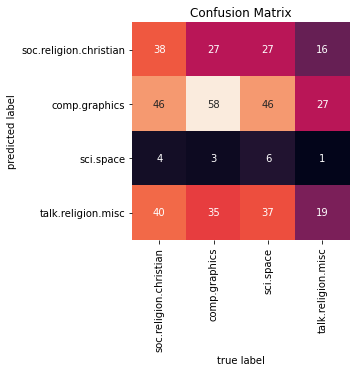

In [105]:
lucem_illud_2020.plotConfusionMatrix(clf_knearest, test_ng_df)

You can produce the PCA space visual if you want, altough it can take a very long time, so we'll leave it optionally commented out:  
如果需要，您可以生成 PCA 空間視覺效果，儘管這可能需要很長時間，因此我們可以選擇將其註釋掉：

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

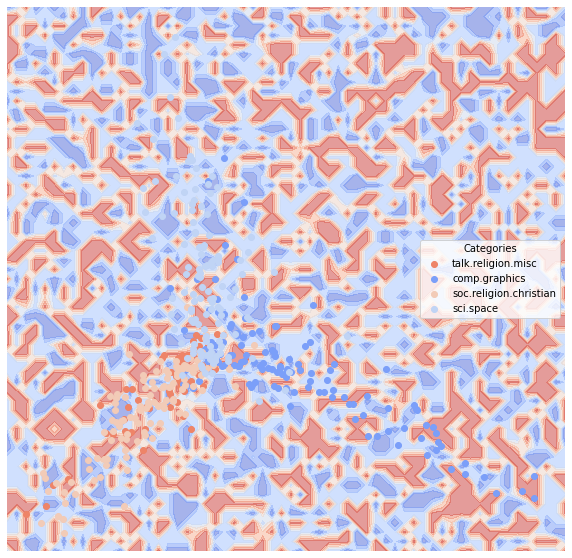

In [107]:
lucem_illud_2020.plotregions(clf_knearest, test_ng_df)

## <span style="color:red">*Exercise 4*</span>

<span style="color:red">In the cells immediately following, perform and visualize k-nearest neighbor classification using training, testing and extrapolation (uncoded) data from texts and hand-classifications associated with your final project. Visualize the classification of data points and calculate relevant metrics (e.g., precision, recall, the F-measure, and AUC). Articulate how the *k*-nearest neighbor approach relates to *k*-means clustering explored in ***week 3***?

## <span style="color:red">*Exercise 4*</span>

<span style="color:red">在緊隨其後的單元格中，使用來自與最終項目相關的文本和手工分類的訓練、測試和外推（未編碼）數據執行和可視化 k 最近鄰分類。可視化數據點的分類併計算相關指標（例如，精度、召回率、F 度量和 AUC）。闡明 k 最近鄰方法與第 3 週探索的 k 均值聚類有何關係？

# SVMs 支援向量機(Support Vector Machine)

Now we will examine Support Vector Machines, an approach that creates the partition that preserves the "maximum margin" between classes.

We will use a few sub forums from reddit--which tend to share text rather than memes--namely `talesfromtechsupport`, `badroommates`, `weeabootales` and `relationships`. The top 100 text posts from each have been saved to `data/reddit.csv`.  
  
現在我們將研究支持向量機，這是一種創建分區的方法，可以保留類之間的“最大餘量”。

我們將使用一些來自 reddit 的子論壇——它們傾向於分享文本而不是模因——即 `talesfromtechsupport`, `badroommates`, `weeabootales` and `relationships`。每個帖子的前 100 個文本帖子已保存到  `data/reddit.csv`. 

In [108]:
redditDf = pandas.read_csv('../data/reddit.csv', index_col = 0)

#Drop a couple missing values

redditDf = redditDf.dropna()

#Set category

redditDf['category'] = redditDf['subreddit']

#tokenize and normalize


redditDf['tokenized_text'] = redditDf['text'].apply(lambda x: lucem_illud_2020.word_tokenize(x))
redditDf['normalized_text'] = redditDf['tokenized_text'].apply(lambda x: lucem_illud_2020.normalizeTokens(x))

We will tf.idf the data to make our vectors:  
我們將 tf.idf 數據製作我們的向量：

這段不用看  

~~改了W108後出現  
empty vocabulary; perhaps the documents only contain stop words
[TfidfVectorizer API說明](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html)  
停止字'enlgisg'看起來有問題要換掉
[6.2.3.3.1. Using stop words](https://scikit-learn.org/stable/modules/feature_extraction.html#stop-words)

~~[Stop Word Lists in Free Open-source Software Packages](https://aclanthology.org/W18-2502/)  
[
stopwords
](https://github.com/igorbrigadir/stopwords)


In [109]:
redditTFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=0.5, min_df=3, stop_words='english', norm='l2')
redditTFVects = redditTFVectorizer.fit_transform([' '.join(l) for l in redditDf['normalized_text']])
redditDf['vect'] = [np.array(v).flatten() for v in redditTFVects.todense()]

Initilize the model and make a train test split:

In [110]:
holdBackFraction = .2
train_redditDf, test_redditDf = lucem_illud_2020.trainTestSplit(redditDf, holdBackFraction=holdBackFraction)

In [111]:
clf_svm = sklearn.svm.SVC(kernel='linear', probability = False)
#probability = True is slower but  lets you call predict_proba()
clf_svm.fit(np.stack(train_redditDf['vect'], axis=0), train_redditDf['category'])

SVC(kernel='linear')

...and consider the results:

In [112]:
lucem_illud_2020.evaluateClassifier(clf_svm, test_redditDf)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
Tales From Tech Support,0.018809,0.983133,0.937500,0.928299,0.986842
Weeaboo Tales: stories about the extreme fans of japanese culture,0.009404,0.985833,0.987805,0.970272,0.975904
Bad Roommates: Tales of Irritation,0.012539,0.983585,0.975610,0.958084,0.975610
Relationships,0.015674,0.972284,0.986667,0.948608,0.948718


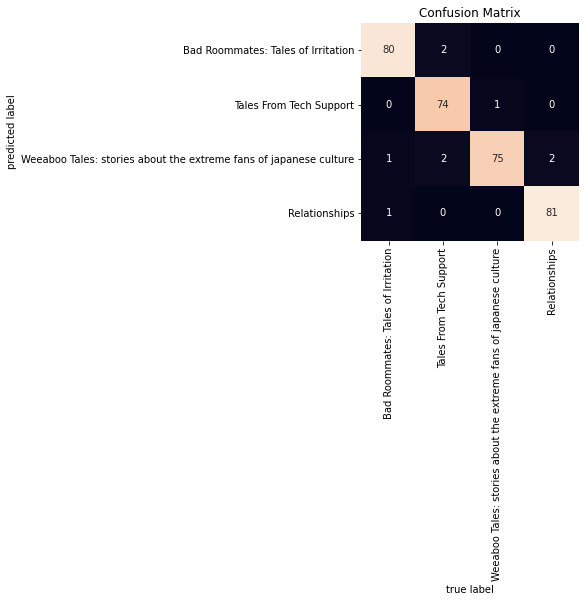

In [113]:
lucem_illud_2020.plotConfusionMatrix(clf_svm, test_redditDf)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

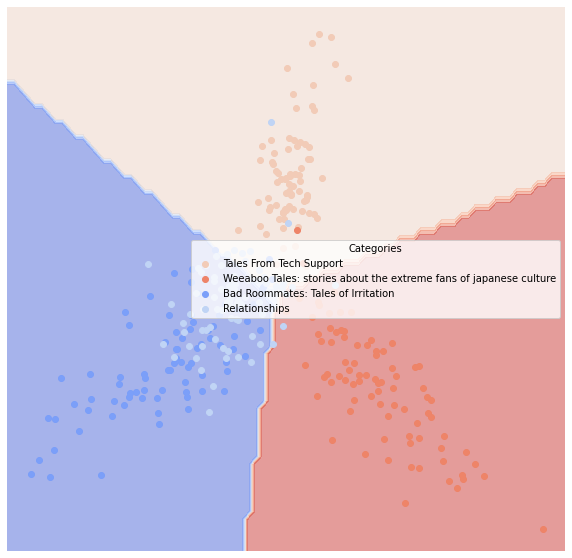

In [114]:
lucem_illud_2020.plotregions(clf_svm, test_redditDf)

# Neural Nets

We include an example of a simple neural network, the Multi-layer Perceptron (MLP) that learns a function $f(\cdot): R^m \rightarrow R^o$ by training on a dataset, where $m$ is the number of dimensions for input and $o$ is the number of dimensions for output. Given a set of features $X = {x_1, x_2, ..., x_m}$ and a target $y$, it can learn a non-linear function approximator for either classification or regression. It is different from logistic regression, in that between the input and the output layer, there can be one or more non-linear layers, called hidden layers. The following figure shows a one hidden layer MLP with scalar output. ![title](../data/multilayerperceptron_network.png) The leftmost layer, known as the input layer, consists of a set of "neurons" $\{x_i | x_1, x_2, ..., x_m\}$ representing the input features (e.g., weighted words). Each neuron in the hidden layer transforms the values from the previous layer with a weighted linear summation $w_1x_1 + w_2x_2 + ... + w_mx_m$, followed by a non-linear activation function $g(\cdot):R \rightarrow R$ - like the logistic or hyperbolic tan function. The output layer receives the values from the last hidden layer and transforms them into output values.

# 神經網絡

我們包括一個簡單神經網絡的示例，即多層感知器 (MLP) 它通過在數據集上訓練學習函數 $f(\cdot): R^m \rightarrow R^o$ , where $m$ 是輸入的維數 and $o$ 是輸出的維數。 給定一組特徵 $X = {x_1, x_2, ..., x_m}$ 和一個目標 $y$, 它可以學習用於分類或回歸的非線性函數逼近器。它與邏輯回歸不同，在輸入層和輸出層之間，可以有一層或多層非線性層，稱為隱藏層。下圖顯示了一個帶有標量輸出的單隱藏層 MLP。
![title](../data/multilayerperceptron_network.png)   
  
最左邊的層，稱為輸入層, 由一組"neurons" $\{x_i | x_1, x_2, ..., x_m\}$ 表示輸入特徵 （例如，加權詞）的“神經元”組成。. Each neuron in the hidden layer transforms the values from the previous layer with a weighted linear summation $w_1x_1 + w_2x_2 + ... + w_mx_m$, followed by a non-linear activation function $g(\cdot):R \rightarrow R$ - like the logistic or hyperbolic tan function. The output layer receives the values from the last hidden layer and transforms them into output values.
  
，隱藏層中的每個神經元都使用加權線性求和來轉換前一層的值，然後是非線性激活函數 - 如邏輯或雙曲正切函數。輸出層接收來自最後一個隱藏層的值並將它們轉換為輸出值。

In [116]:
clf_nn = sklearn.neural_network.MLPClassifier()
clf_nn.fit(np.stack(train_redditDf['vect'], axis=0), train_redditDf['category'])

MLPClassifier()

In [117]:
lucem_illud_2020.evaluateClassifier(clf_nn, test_redditDf)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
Tales From Tech Support,0.018809,0.978612,0.948718,0.930021,0.973684
Weeaboo Tales: stories about the extreme fans of japanese culture,0.012539,0.979809,0.987654,0.961360,0.963855
Bad Roommates: Tales of Irritation,0.018809,0.975378,0.963415,0.937572,0.963415
Relationships,0.037618,0.949090,0.923077,0.870880,0.923077


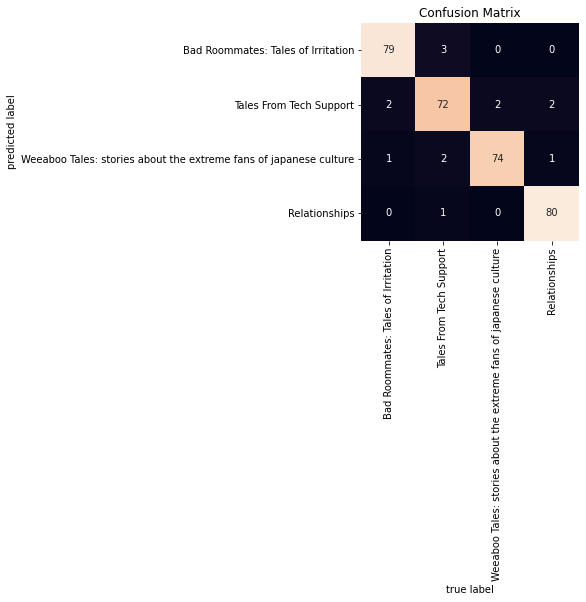

In [118]:
lucem_illud_2020.plotConfusionMatrix(clf_nn, test_redditDf)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

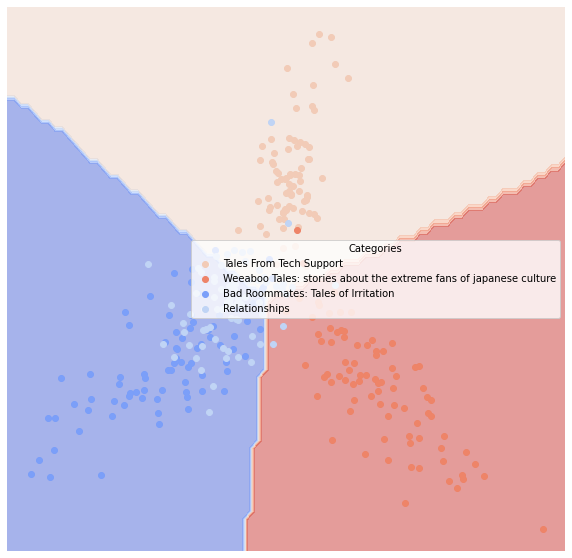

In [119]:
lucem_illud_2020.plotregions(clf_nn, test_redditDf)

It performs very well.  
它的表現非常好。

## <span style="color:red">*Exercise 5*</span>

<span style="color:red">In the cells immediately following, perform a neural network classification and calculate relevant metrics (e.g., precision, recall, the F-measure, and AUC). How does this classify relevant to *k*-nearest neighbor, Naive Bayes, logistic and decision-tree approaches?

## <span style="color:red">*Exercise 5*</span>

<span style="color:red">在緊隨其後的單元格中，執行神經網絡分類併計算相關指標（例如，精度、召回率、F 度量和 AUC）。這與 k 最近鄰、單純貝葉斯、邏輯和決策樹方法有什麼關係？